In [6]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hstack', 'cholesky', 'identity']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [113]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [8]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [9]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    params['u_sol']=u
    params['ux']=ux
    params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    print(len(MP.mesh.domains))
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6))
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])


        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_ind = adap.PoissonEstimator(MP,uh,f)
            err_est[iter] = norm(err_ind)
            marked_patches = adap.doerfler_marking(err_ind, theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            #print(MP.numdofs)
            start = time.time()
            M.split_patches(patches=marked_patches)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            print("")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est

In [10]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6))
            plt.axis('scaled');
            plt.show()
            
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
            
        if iter < maxiter-1:
            start=time.time()
            M.refine()
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [11]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0

0


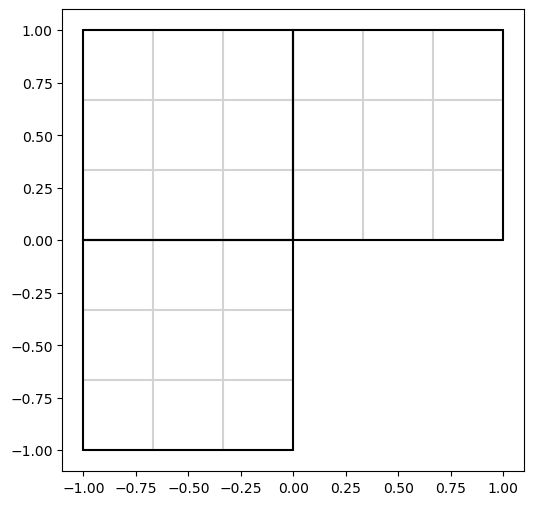

Refinement took 0.0001556873321533203 seconds.
1


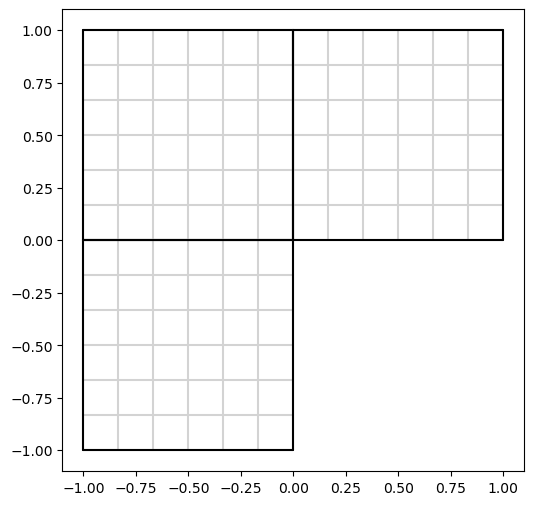

Refinement took 0.00019311904907226562 seconds.
2


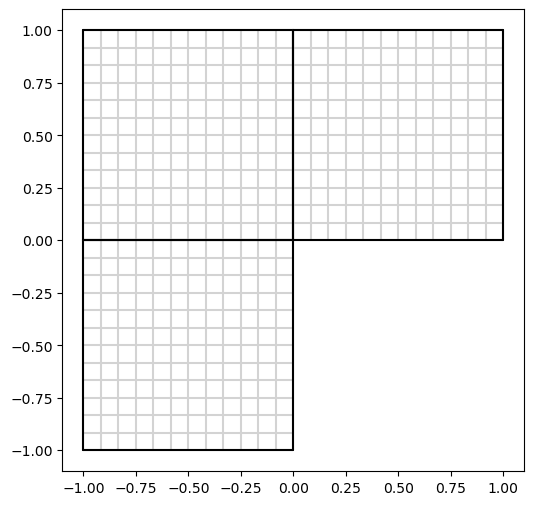

Refinement took 0.0001647472381591797 seconds.
3


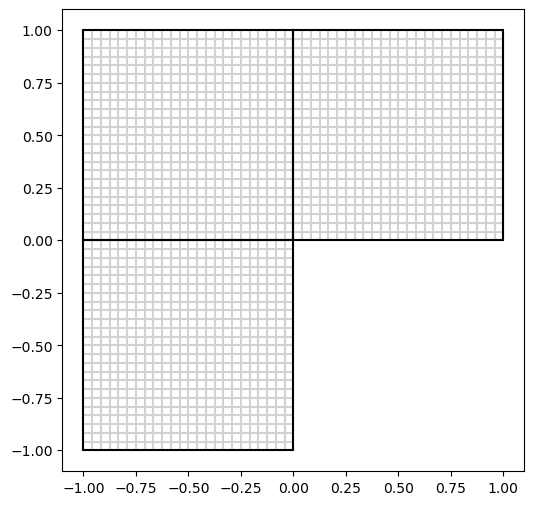

Refinement took 0.0002319812774658203 seconds.
4


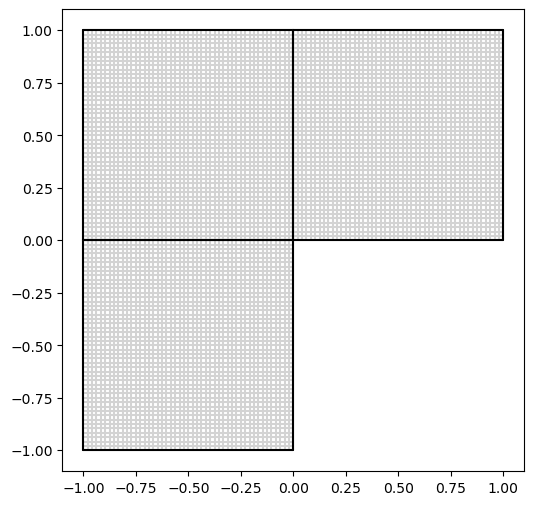

Refinement took 0.00020051002502441406 seconds.
5


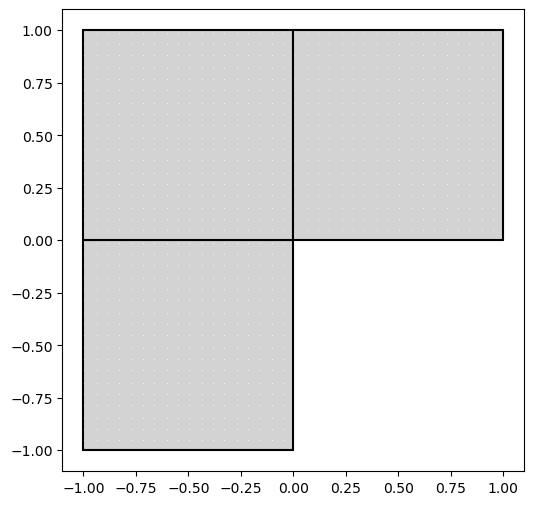

Refinement took 0.00021529197692871094 seconds.
6


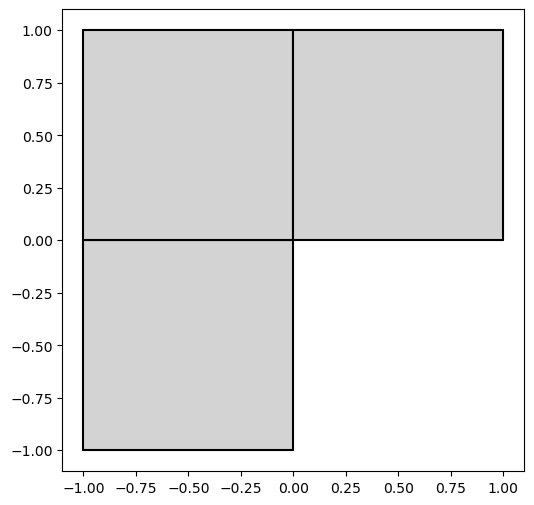

Refinement took 0.0003249645233154297 seconds.
7


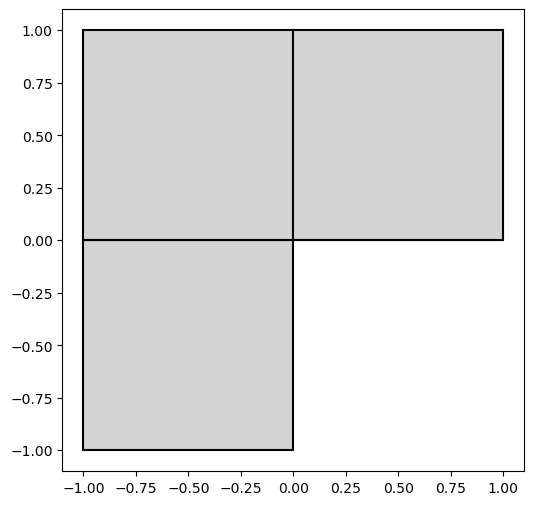

Refinement took 0.0003612041473388672 seconds.
8


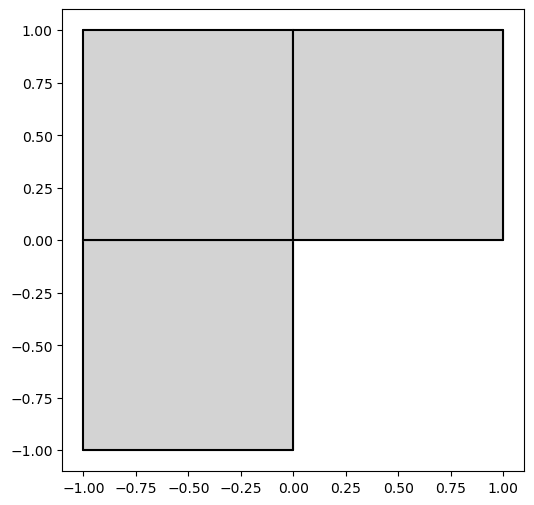

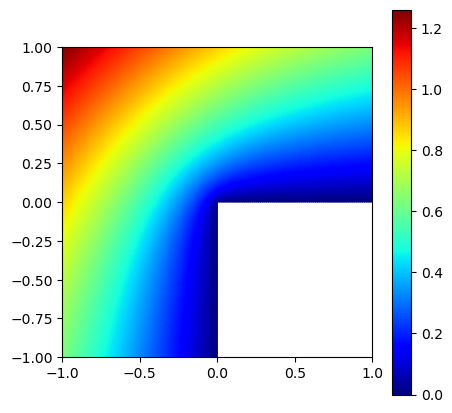

In [200]:
M = Lshape(2,3)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=9, draw=True)
#M.draw()

1
0


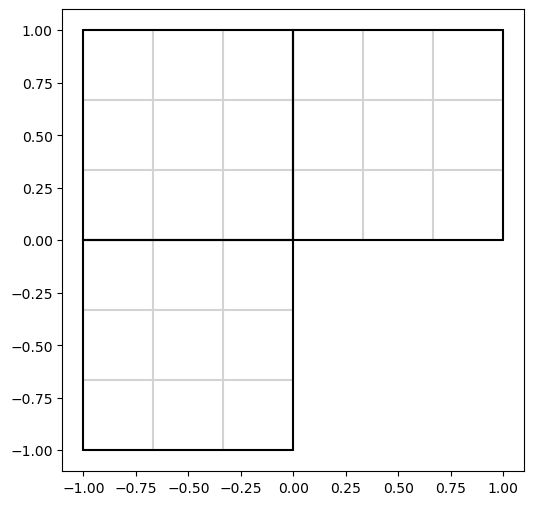

Residual contributions took 0.02008199691772461 seconds.
Jump contributions took 0.012343168258666992 seconds.
Estimate and Marking took 0.03257441520690918 seconds.
Refinement took 0.00835561752319336 seconds.

1


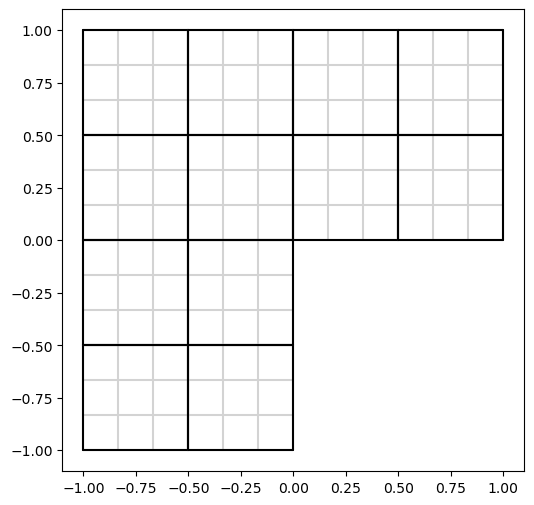

Residual contributions took 0.07737541198730469 seconds.
Jump contributions took 0.10830044746398926 seconds.
Estimate and Marking took 0.1858539581298828 seconds.
Refinement took 0.010361909866333008 seconds.

2


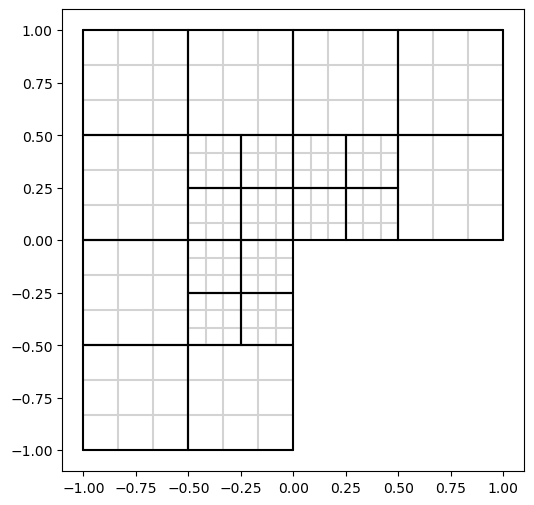

Residual contributions took 0.13347291946411133 seconds.
Jump contributions took 0.24291348457336426 seconds.
Estimate and Marking took 0.3766026496887207 seconds.
Refinement took 0.012723684310913086 seconds.

3


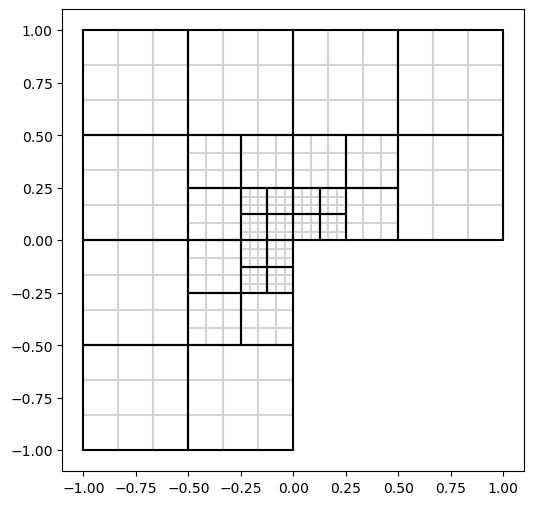

Residual contributions took 0.1904454231262207 seconds.
Jump contributions took 0.37734270095825195 seconds.
Estimate and Marking took 0.5683188438415527 seconds.
Refinement took 0.01395416259765625 seconds.

4


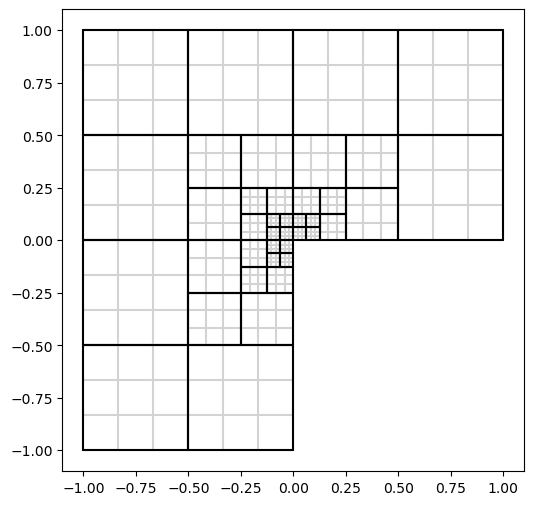

Residual contributions took 0.2521805763244629 seconds.
Jump contributions took 0.5103862285614014 seconds.
Estimate and Marking took 0.7627990245819092 seconds.
Refinement took 0.016254186630249023 seconds.

5


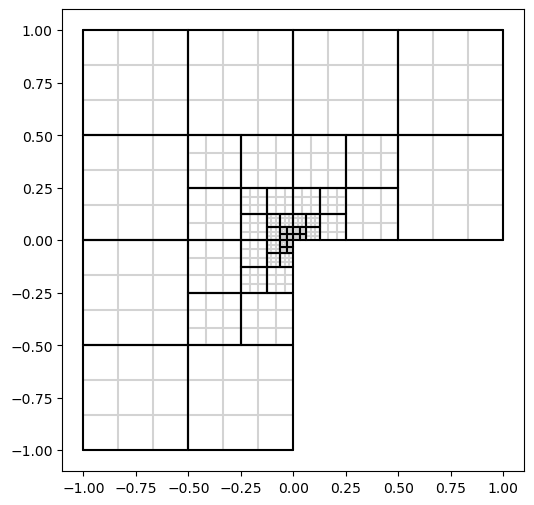

Residual contributions took 0.30726075172424316 seconds.
Jump contributions took 0.6513278484344482 seconds.
Estimate and Marking took 0.9588301181793213 seconds.
Refinement took 0.018107891082763672 seconds.

6


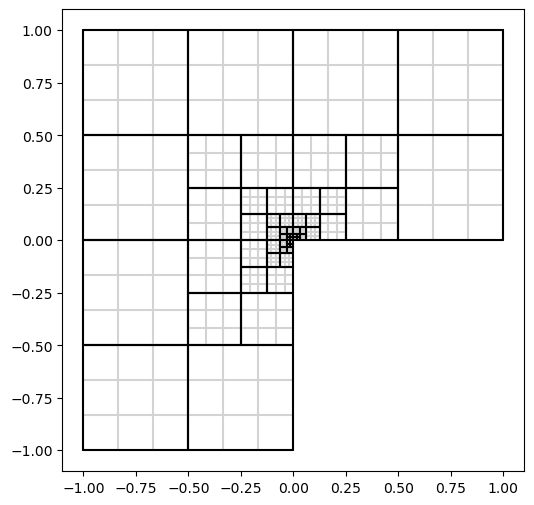

Residual contributions took 0.3639540672302246 seconds.
Jump contributions took 0.7807486057281494 seconds.
Estimate and Marking took 1.1449589729309082 seconds.
Refinement took 0.020273923873901367 seconds.

7


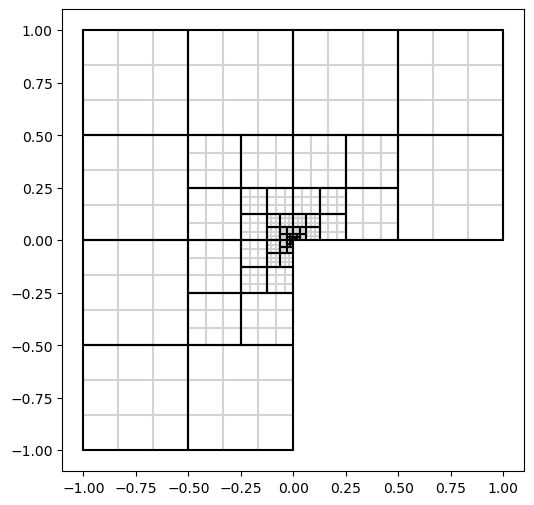

Residual contributions took 0.42282605171203613 seconds.
Jump contributions took 0.9158978462219238 seconds.
Estimate and Marking took 1.3391053676605225 seconds.
Refinement took 0.02167677879333496 seconds.

8


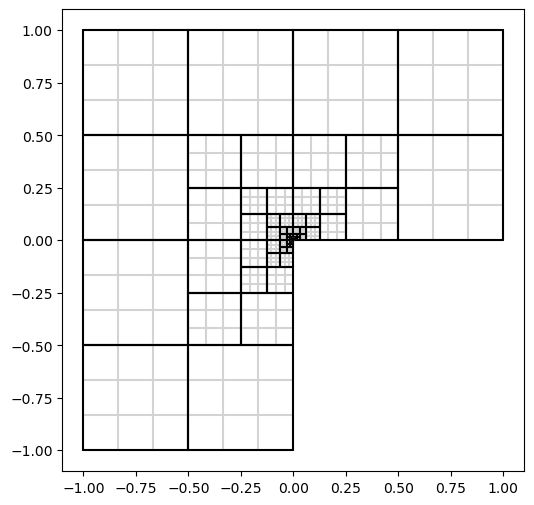

Residual contributions took 0.48145556449890137 seconds.
Jump contributions took 1.048121690750122 seconds.
Estimate and Marking took 1.5299878120422363 seconds.
Refinement took 0.023389577865600586 seconds.

9


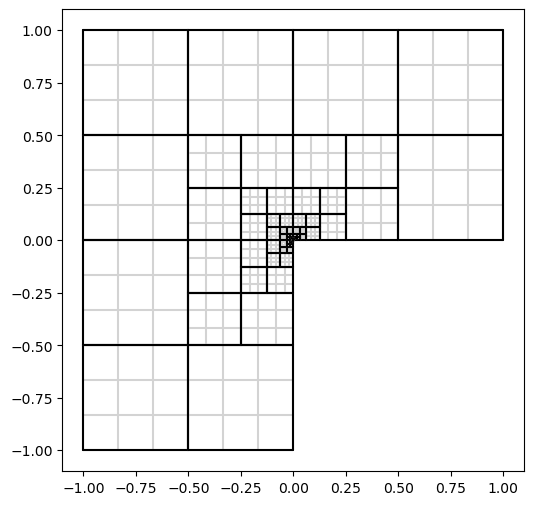

Residual contributions took 0.5393040180206299 seconds.
Jump contributions took 1.3377492427825928 seconds.
Estimate and Marking took 1.8773186206817627 seconds.
Refinement took 0.05520510673522949 seconds.

10


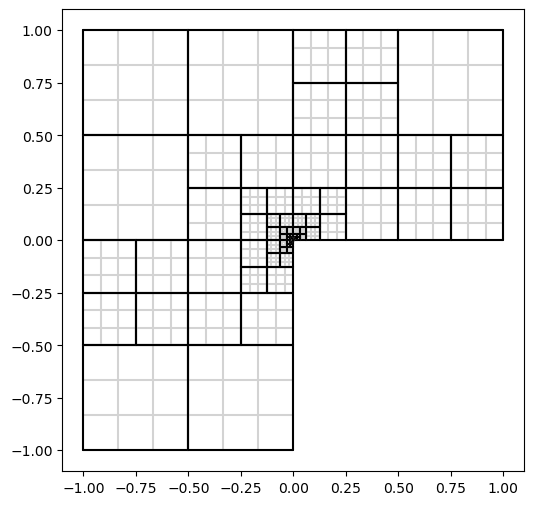

Residual contributions took 0.6478631496429443 seconds.
Jump contributions took 1.4322113990783691 seconds.
Estimate and Marking took 2.0806586742401123 seconds.
Refinement took 0.12476849555969238 seconds.

11


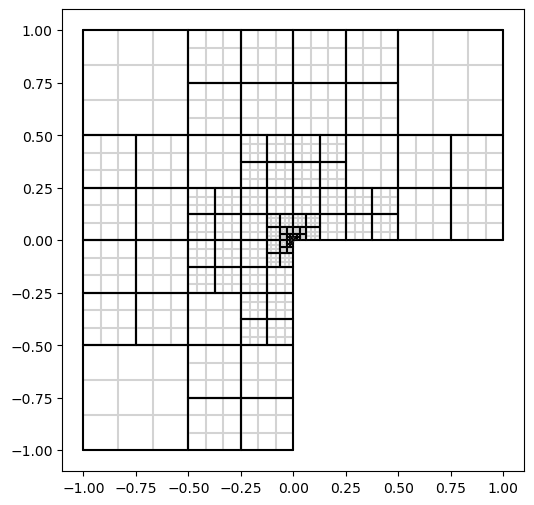

Residual contributions took 0.8743603229522705 seconds.
Jump contributions took 1.9230093955993652 seconds.
Estimate and Marking took 2.7980337142944336 seconds.
Refinement took 0.1915268898010254 seconds.

12


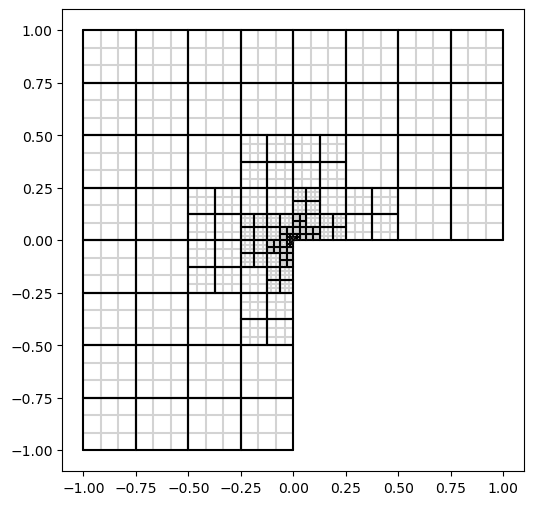

Residual contributions took 1.1664373874664307 seconds.
Jump contributions took 2.7094290256500244 seconds.
Estimate and Marking took 3.8764126300811768 seconds.
Refinement took 0.3379490375518799 seconds.

13


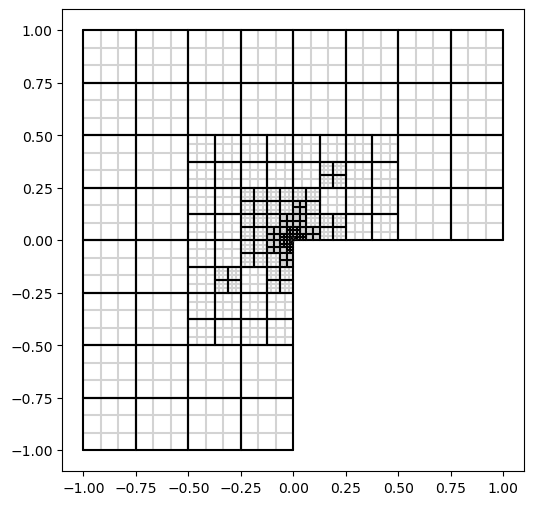

Residual contributions took 1.5303425788879395 seconds.
Jump contributions took 3.568943977355957 seconds.
Estimate and Marking took 5.100056171417236 seconds.
Refinement took 0.6484420299530029 seconds.

14


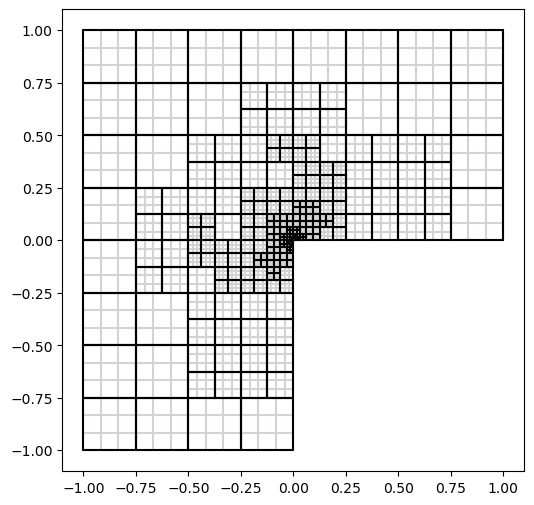

Residual contributions took 2.109893560409546 seconds.
Jump contributions took 4.735134601593018 seconds.
Estimate and Marking took 6.845952987670898 seconds.
Refinement took 1.3860886096954346 seconds.

15


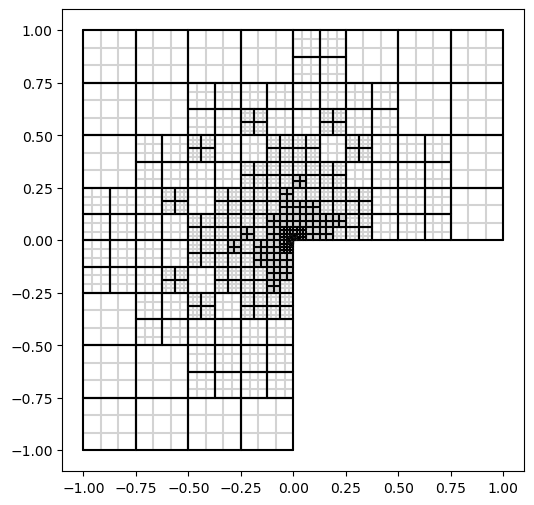

Residual contributions took 3.102447271347046 seconds.
Jump contributions took 6.940537214279175 seconds.
Estimate and Marking took 10.04408574104309 seconds.
Refinement took 2.820380926132202 seconds.

16


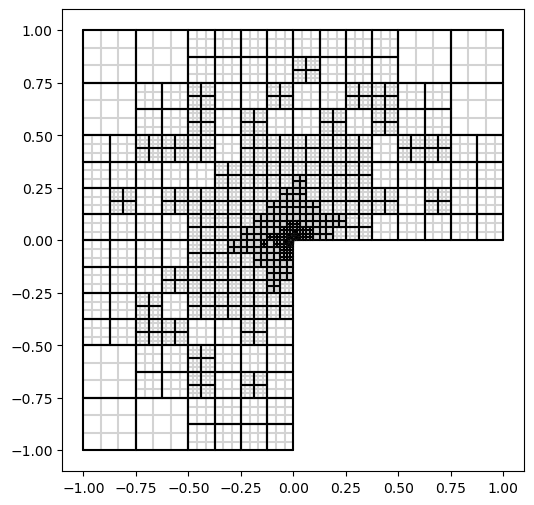

Residual contributions took 4.455574989318848 seconds.
Jump contributions took 10.015626668930054 seconds.
Estimate and Marking took 14.472594499588013 seconds.
Refinement took 5.291111946105957 seconds.

17


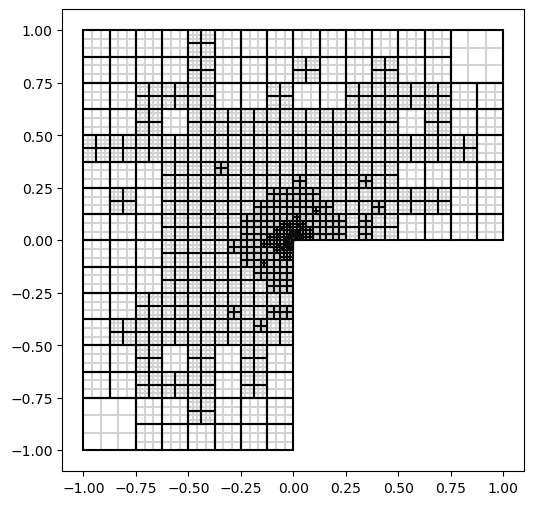

Residual contributions took 6.439371824264526 seconds.
Jump contributions took 14.831193447113037 seconds.
Estimate and Marking took 21.272439002990723 seconds.
Refinement took 10.306880712509155 seconds.

18


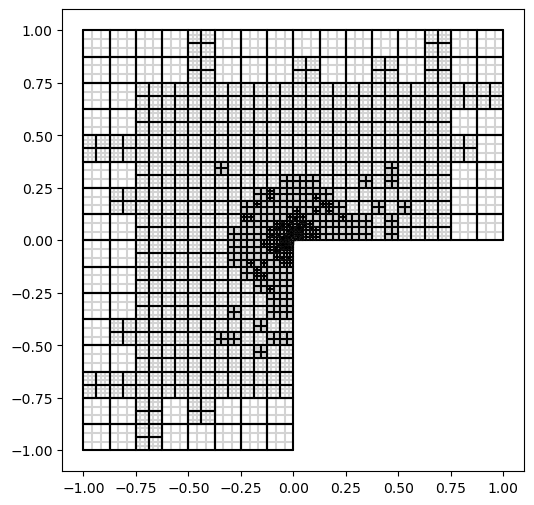

Residual contributions took 9.134242057800293 seconds.
Jump contributions took 20.617250680923462 seconds.
Estimate and Marking took 29.754220008850098 seconds.
Refinement took 20.999797344207764 seconds.

19


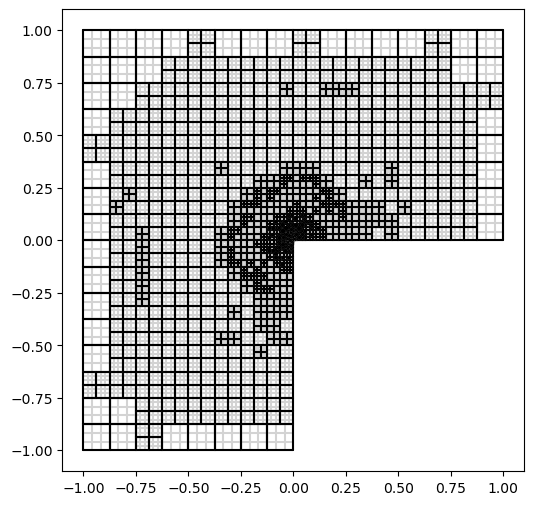

Residual contributions took 13.012084722518921 seconds.
Jump contributions took 29.430160999298096 seconds.
Estimate and Marking took 42.44681739807129 seconds.
Refinement took 44.10217785835266 seconds.

20


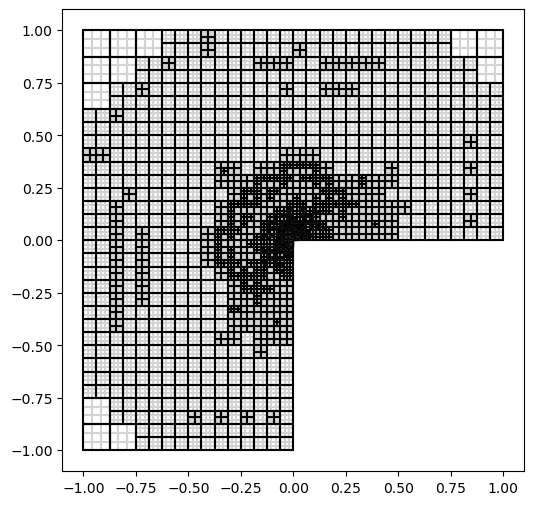

Residual contributions took 18.90710711479187 seconds.
Jump contributions took 42.644588470458984 seconds.
Estimate and Marking took 61.55818843841553 seconds.
Refinement took 79.67222905158997 seconds.

21


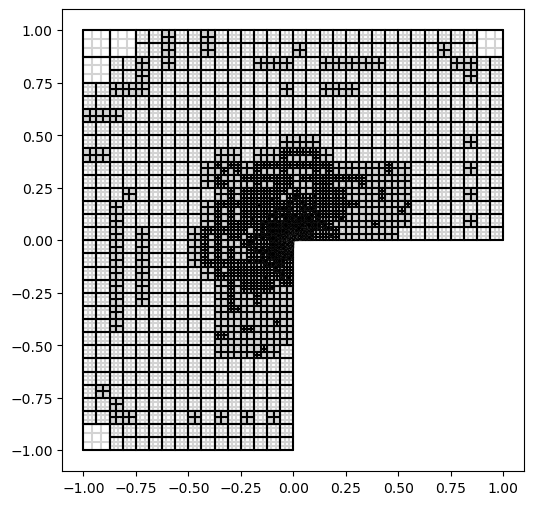

Residual contributions took 26.438859462738037 seconds.
Jump contributions took 59.91735529899597 seconds.
Estimate and Marking took 86.36668562889099 seconds.
Refinement took 149.23030400276184 seconds.

22


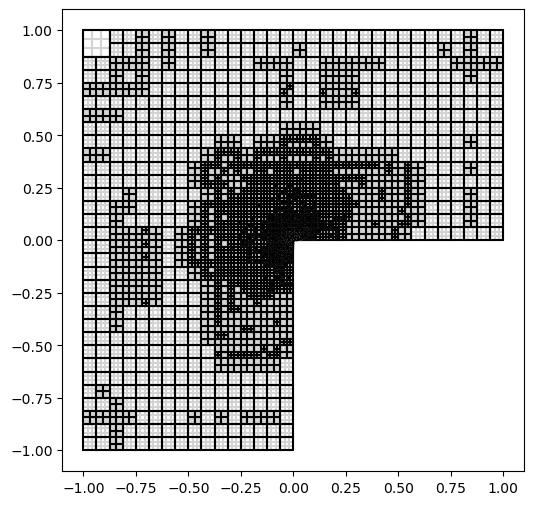

Residual contributions took 36.54888033866882 seconds.
Jump contributions took 83.36186099052429 seconds.
Estimate and Marking took 119.9297833442688 seconds.
Refinement took 298.40641474723816 seconds.

23


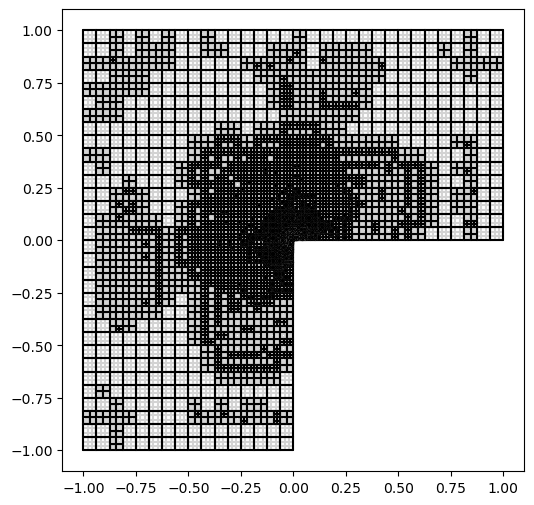

Residual contributions took 51.10836052894592 seconds.
Jump contributions took 116.74937391281128 seconds.
Estimate and Marking took 167.89222598075867 seconds.
Refinement took 601.571799993515 seconds.

24


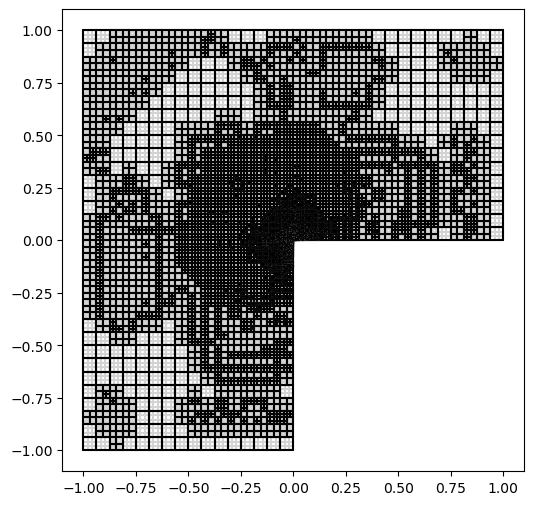

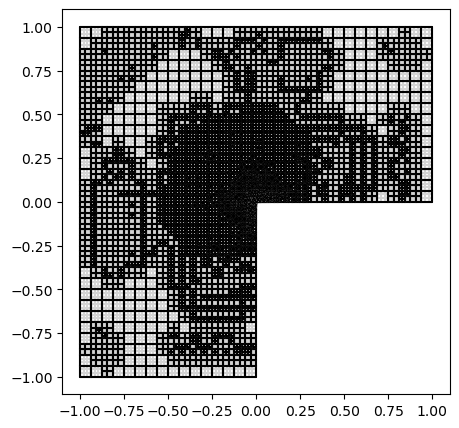

In [14]:
M = Lshape(2,3)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=25)
M.draw()

In [15]:
np.savetxt('Lp2n3.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

In [194]:
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp2n3.txt').reshape((4,23))

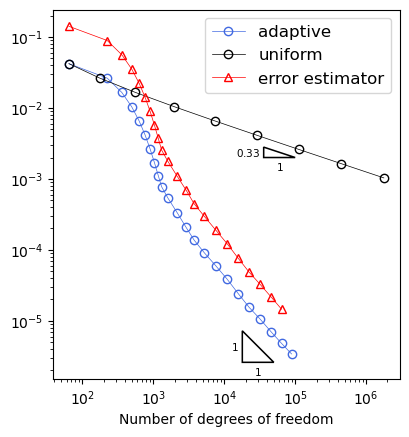

In [201]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform','error estimator'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.5*1e5,2.6*1e-6),2,1,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.2*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

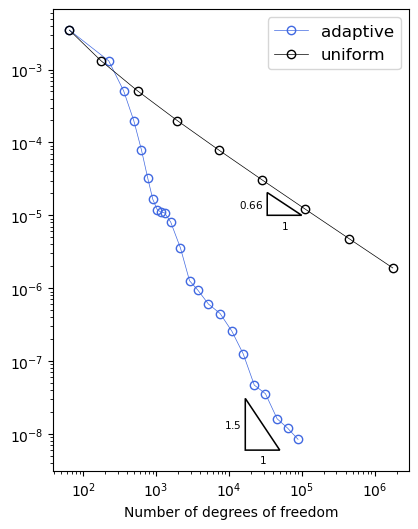

In [204]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.5*1e5,0.6*1e-8),2,slope=1.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.1*1e-4),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

0
Refinement took 0.00015020370483398438 seconds.
1
Refinement took 0.0001766681671142578 seconds.
2
Refinement took 0.00023365020751953125 seconds.
3
Refinement took 0.0002865791320800781 seconds.
4
Refinement took 0.00021004676818847656 seconds.
5
Refinement took 0.00024890899658203125 seconds.
6
Refinement took 0.0003120899200439453 seconds.
7
Refinement took 0.000396728515625 seconds.
8


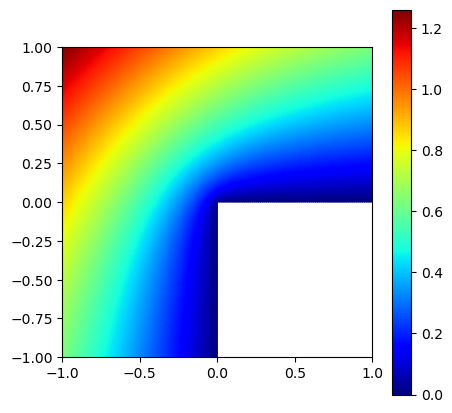

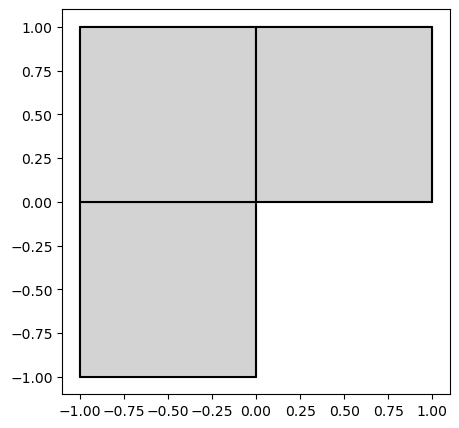

In [205]:
M = Lshape(3,4)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=8, draw=False)
M.draw()

1
0


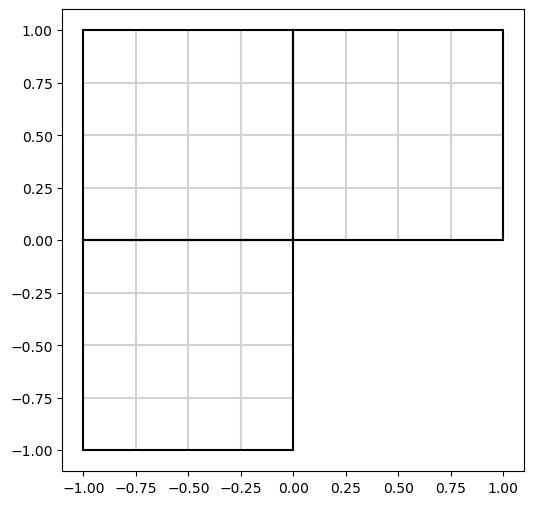

Residual contributions took 0.019572734832763672 seconds.
Jump contributions took 0.012486934661865234 seconds.
Estimate and Marking took 0.03220677375793457 seconds.
Refinement took 0.005731821060180664 seconds.

1


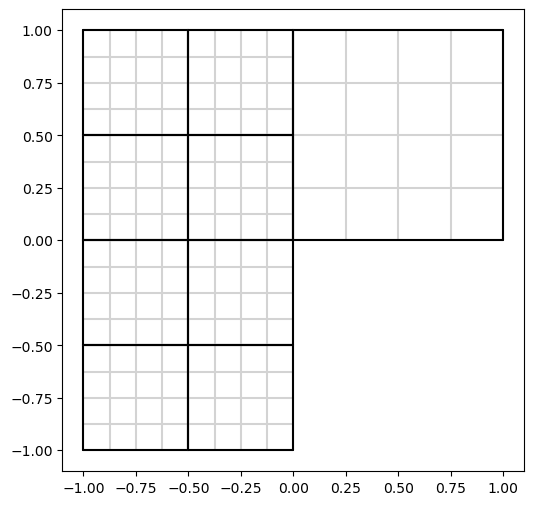

Residual contributions took 0.058766841888427734 seconds.
Jump contributions took 0.08199787139892578 seconds.
Estimate and Marking took 0.14091038703918457 seconds.
Refinement took 0.00635218620300293 seconds.

2


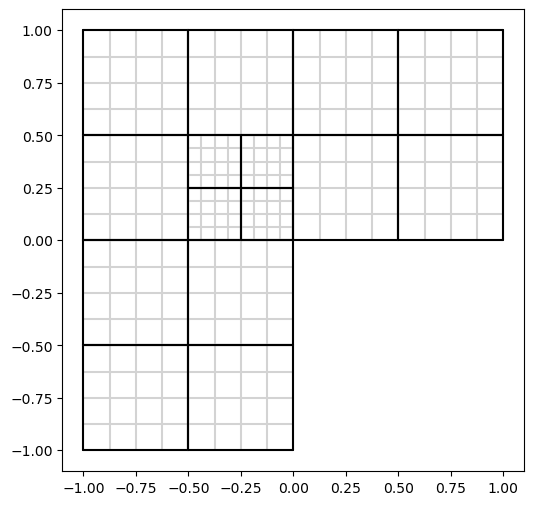

Residual contributions took 0.09934163093566895 seconds.
Jump contributions took 0.16340017318725586 seconds.
Estimate and Marking took 0.2629070281982422 seconds.
Refinement took 0.010952234268188477 seconds.

3


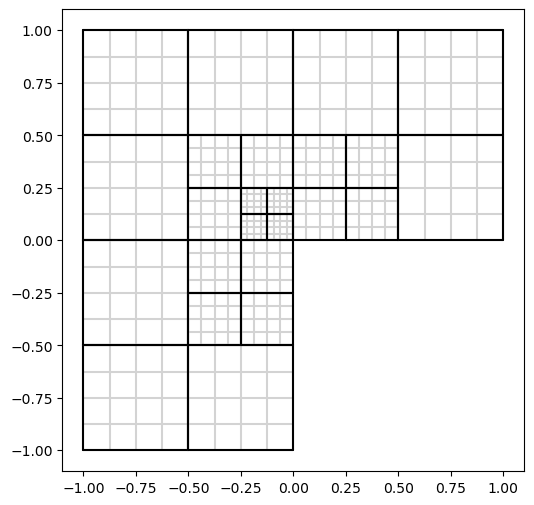

Residual contributions took 0.15537142753601074 seconds.
Jump contributions took 0.3019828796386719 seconds.
Estimate and Marking took 0.45757150650024414 seconds.
Refinement took 0.01334381103515625 seconds.

4


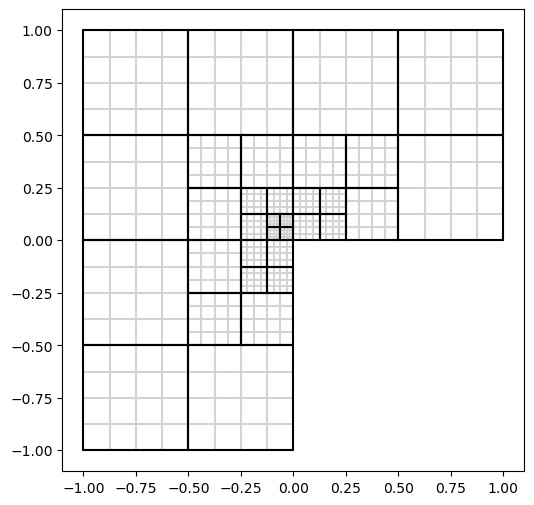

Residual contributions took 0.21670269966125488 seconds.
Jump contributions took 0.45432543754577637 seconds.
Estimate and Marking took 0.6712923049926758 seconds.
Refinement took 0.015439510345458984 seconds.

5


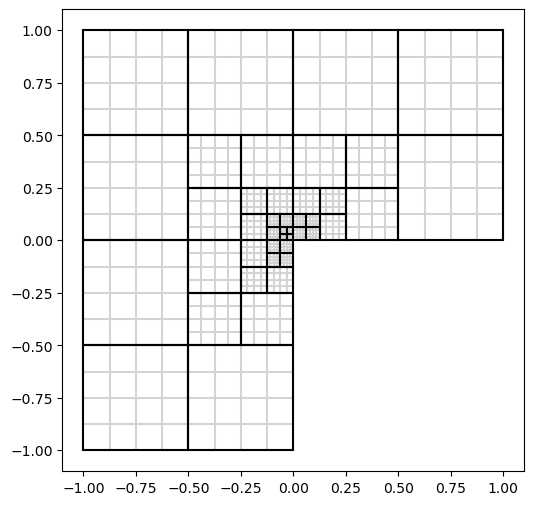

Residual contributions took 0.2697567939758301 seconds.
Jump contributions took 0.5722484588623047 seconds.
Estimate and Marking took 0.8423974514007568 seconds.
Refinement took 0.0169370174407959 seconds.

6


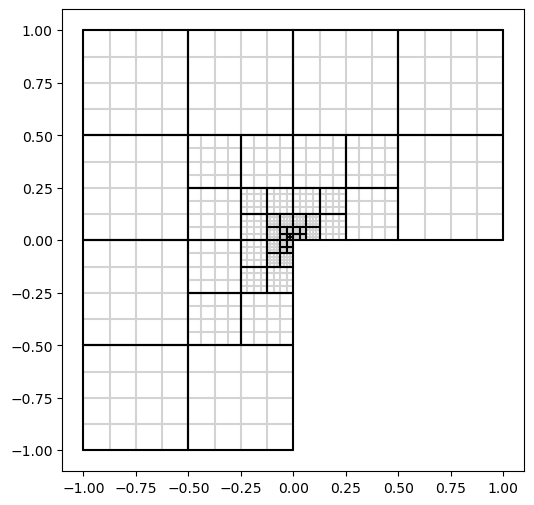

Residual contributions took 0.3280372619628906 seconds.
Jump contributions took 0.7066605091094971 seconds.
Estimate and Marking took 1.0349454879760742 seconds.
Refinement took 0.01909947395324707 seconds.

7


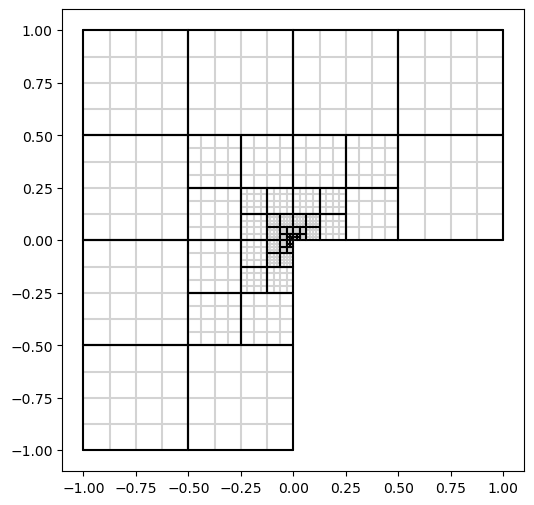

Residual contributions took 0.38579678535461426 seconds.
Jump contributions took 0.8416810035705566 seconds.
Estimate and Marking took 1.2277209758758545 seconds.
Refinement took 0.02119898796081543 seconds.

8


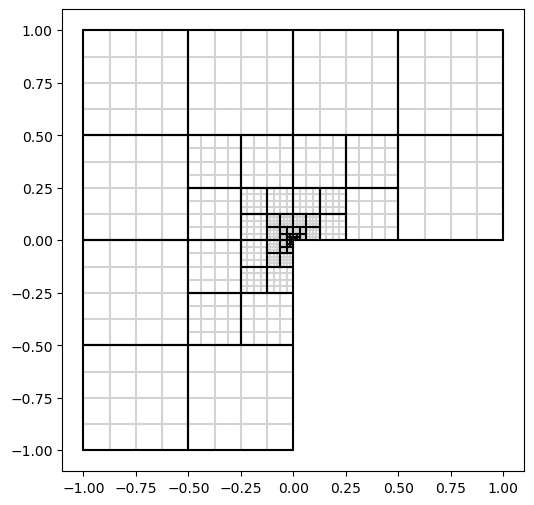

Residual contributions took 0.44953322410583496 seconds.
Jump contributions took 0.9788079261779785 seconds.
Estimate and Marking took 1.4288997650146484 seconds.
Refinement took 0.022715330123901367 seconds.

9


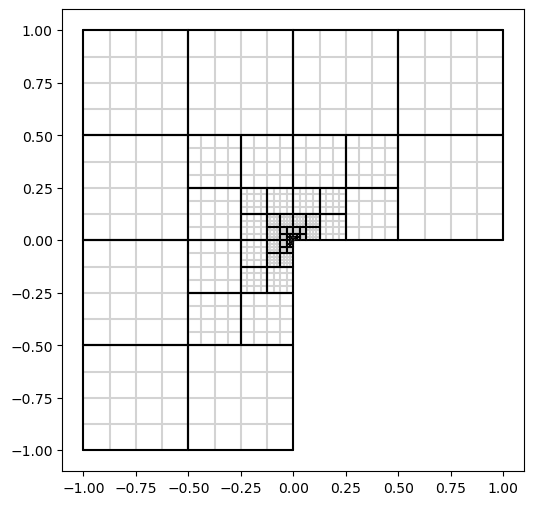

Residual contributions took 0.5037288665771484 seconds.
Jump contributions took 1.1235573291778564 seconds.
Estimate and Marking took 1.6275596618652344 seconds.
Refinement took 0.025536060333251953 seconds.

10


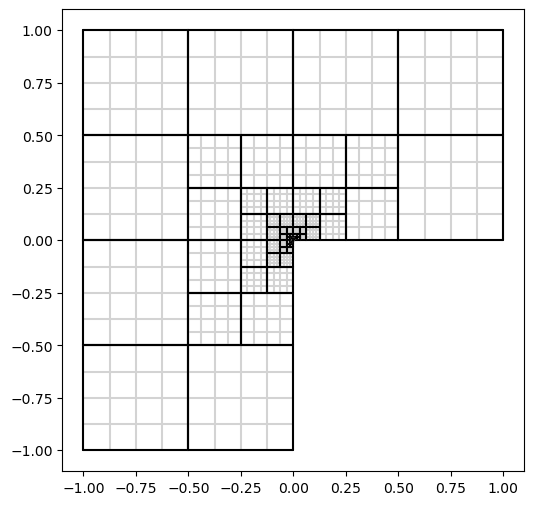

Residual contributions took 0.5665261745452881 seconds.
Jump contributions took 1.2560465335845947 seconds.
Estimate and Marking took 1.8230011463165283 seconds.
Refinement took 0.026690244674682617 seconds.

11


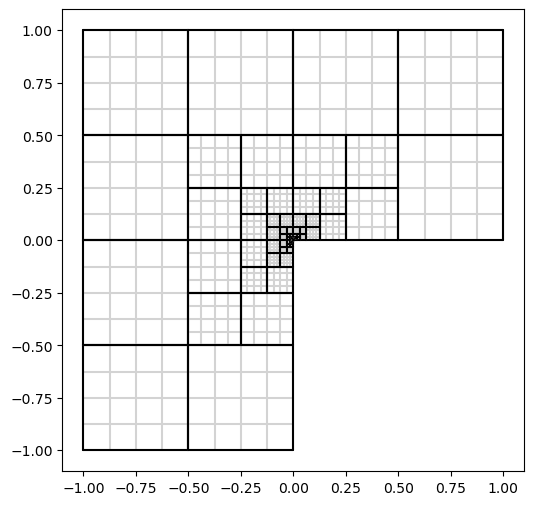

Residual contributions took 0.616008996963501 seconds.
Jump contributions took 1.3931138515472412 seconds.
Estimate and Marking took 2.0093908309936523 seconds.
Refinement took 0.02883458137512207 seconds.

12


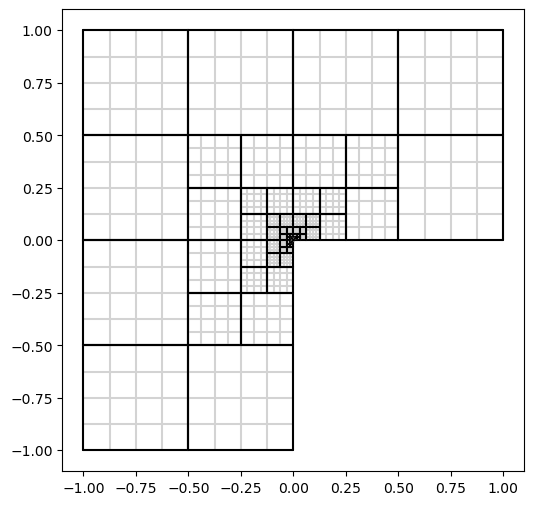

Residual contributions took 0.6763157844543457 seconds.
Jump contributions took 1.5275413990020752 seconds.
Estimate and Marking took 2.2041690349578857 seconds.
Refinement took 0.05252575874328613 seconds.

13


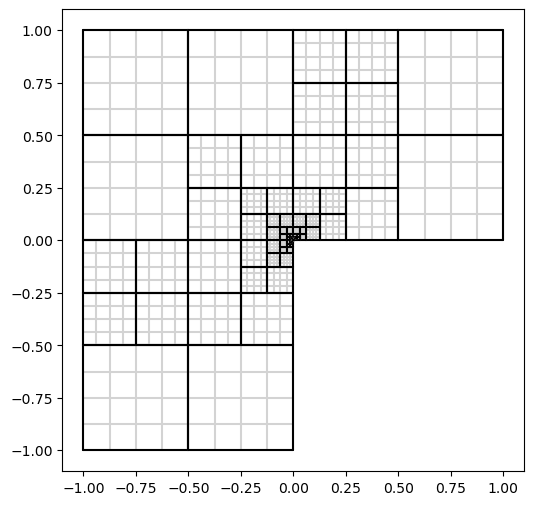

Residual contributions took 0.742041826248169 seconds.
Jump contributions took 1.8863697052001953 seconds.
Estimate and Marking took 2.6288037300109863 seconds.
Refinement took 0.10751819610595703 seconds.

14


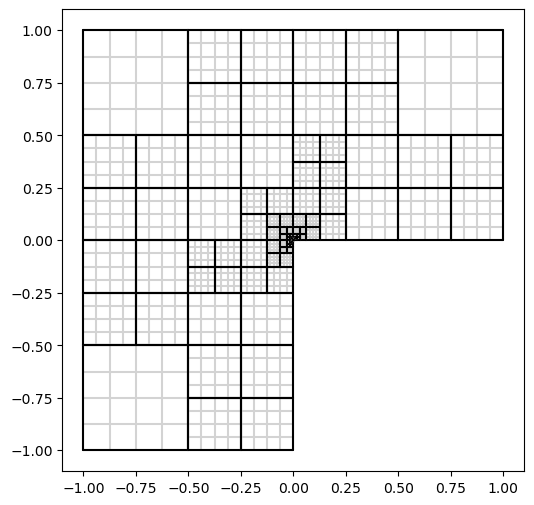

Residual contributions took 0.9213550090789795 seconds.
Jump contributions took 2.118746757507324 seconds.
Estimate and Marking took 3.0407497882843018 seconds.
Refinement took 0.13633465766906738 seconds.

15


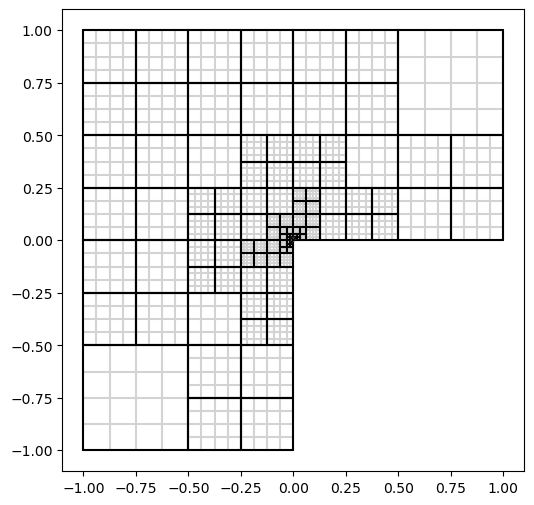

Residual contributions took 1.1096899509429932 seconds.
Jump contributions took 2.548247814178467 seconds.
Estimate and Marking took 3.6586265563964844 seconds.
Refinement took 0.20849275588989258 seconds.

16


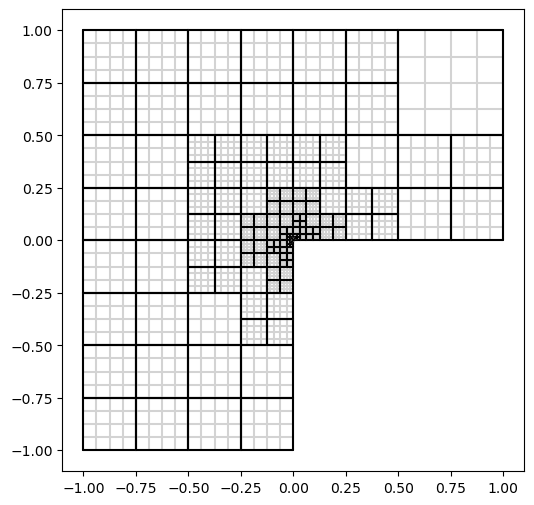

Residual contributions took 1.3736579418182373 seconds.
Jump contributions took 3.0865120887756348 seconds.
Estimate and Marking took 4.460904121398926 seconds.
Refinement took 0.3180959224700928 seconds.

17


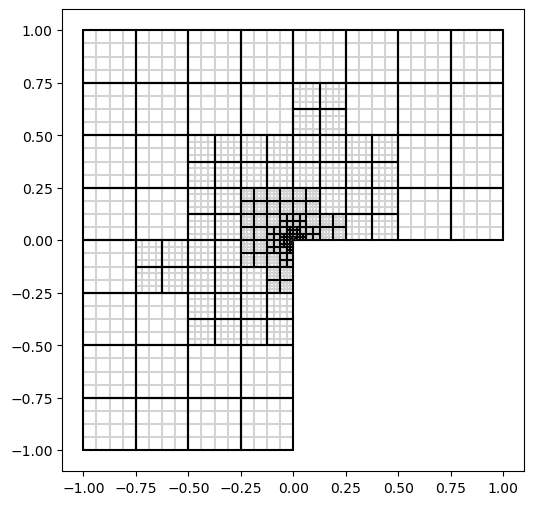

Residual contributions took 1.7077298164367676 seconds.
Jump contributions took 3.8446428775787354 seconds.
Estimate and Marking took 5.553150177001953 seconds.
Refinement took 0.5890963077545166 seconds.

18


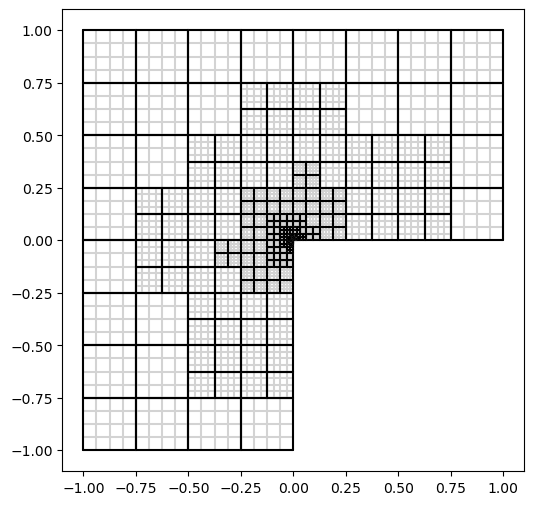

Residual contributions took 2.2237231731414795 seconds.
Jump contributions took 4.923717260360718 seconds.
Estimate and Marking took 7.148325443267822 seconds.
Refinement took 0.97422194480896 seconds.

19


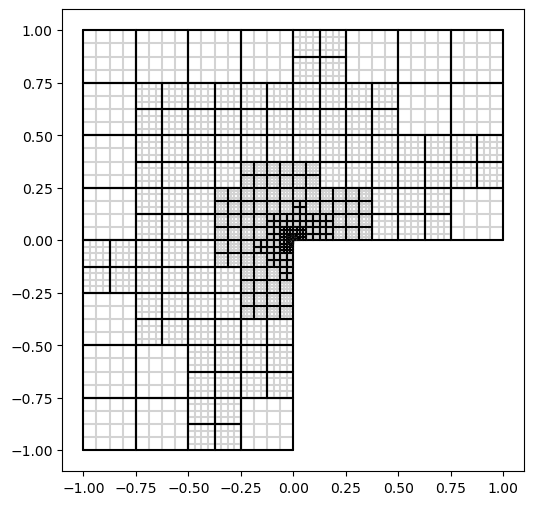

Residual contributions took 2.8270204067230225 seconds.
Jump contributions took 6.389181852340698 seconds.
Estimate and Marking took 9.21714448928833 seconds.
Refinement took 1.5938053131103516 seconds.

20


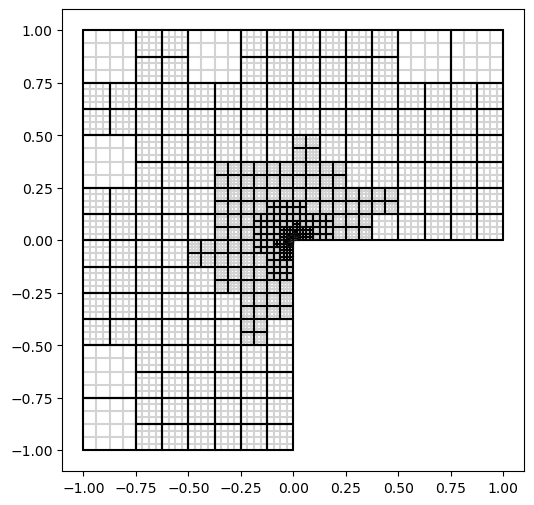

Residual contributions took 3.815727949142456 seconds.
Jump contributions took 8.41675877571106 seconds.
Estimate and Marking took 12.23324704170227 seconds.
Refinement took 0.11594772338867188 seconds.

21


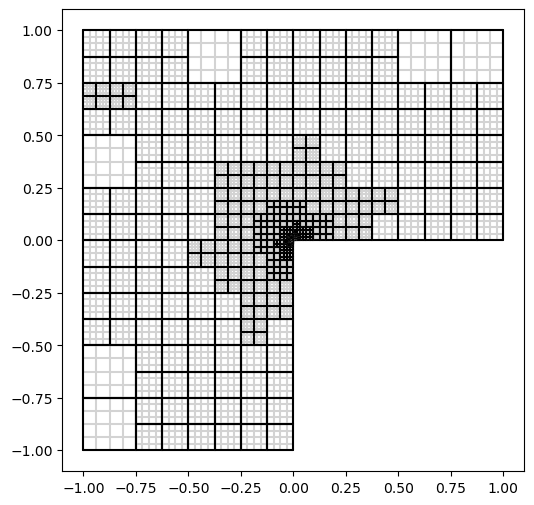

Residual contributions took 3.826462745666504 seconds.
Jump contributions took 8.425493717193604 seconds.
Estimate and Marking took 12.252973794937134 seconds.
Refinement took 2.562934398651123 seconds.

22


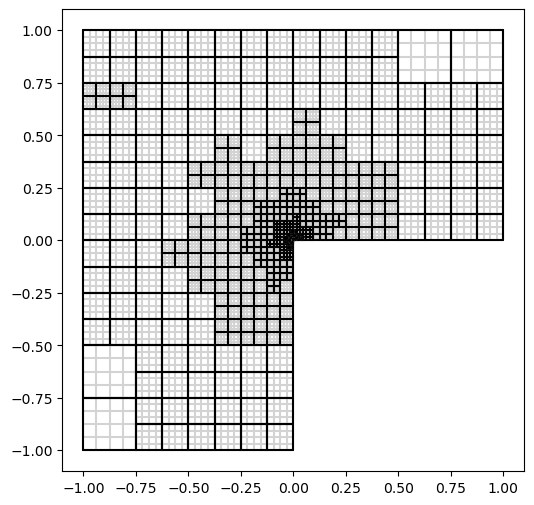

Residual contributions took 5.328736066818237 seconds.
Jump contributions took 10.9115149974823 seconds.
Estimate and Marking took 16.241756916046143 seconds.
Refinement took 4.532428979873657 seconds.

23


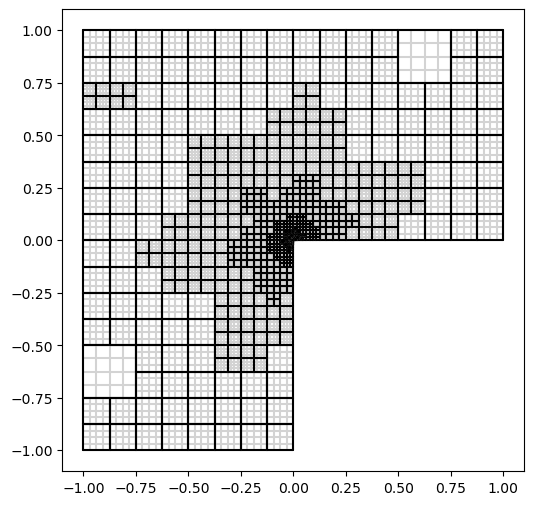

Residual contributions took 6.543043851852417 seconds.
Jump contributions took 14.581004619598389 seconds.
Estimate and Marking took 21.12567663192749 seconds.
Refinement took 8.177096128463745 seconds.

24


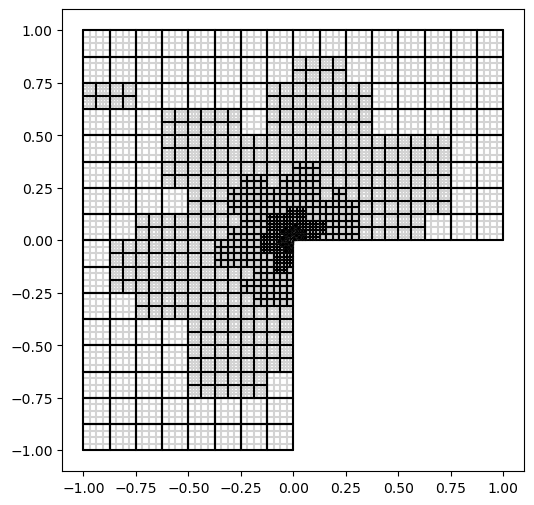

Residual contributions took 8.589442014694214 seconds.
Jump contributions took 18.953317880630493 seconds.
Estimate and Marking took 27.545021295547485 seconds.
Refinement took 14.143296241760254 seconds.

25


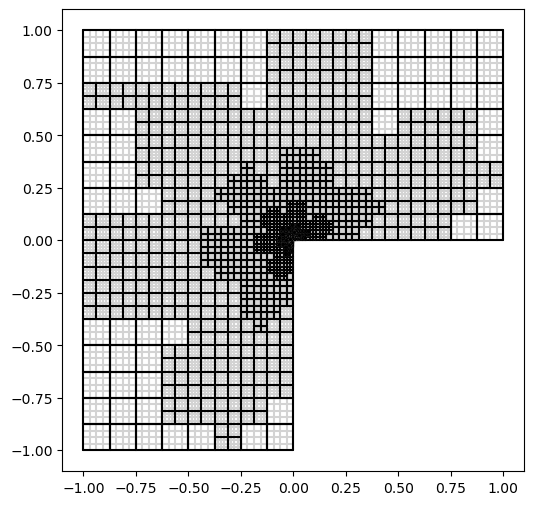

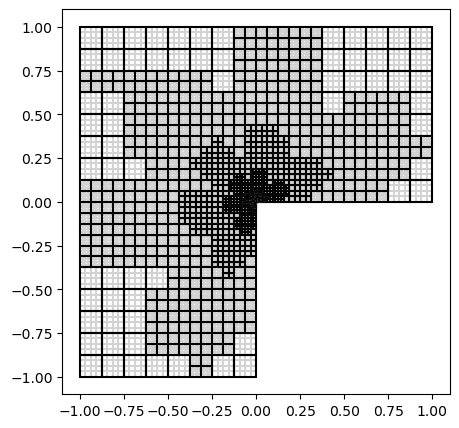

In [206]:
M = Lshape(3,4)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=26)
M.draw()

In [207]:
np.savetxt('Lp3n4.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

In [225]:
H1err_a=np.delete(H1err_a,20)

In [226]:
L2err_a=np.delete(L2err_a,20)

In [228]:
numdofs_a=np.delete(numdofs_a,20)

In [229]:
err_est=np.delete(err_est,20)

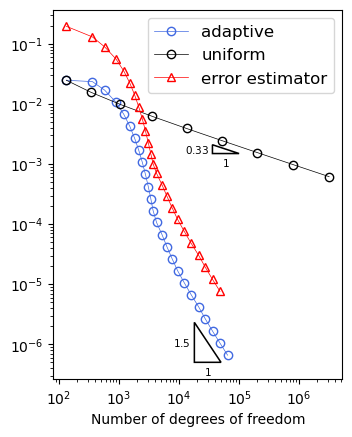

In [234]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform','error estimator'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.5*1e5,0.5*1e-6),2,1.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.15*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

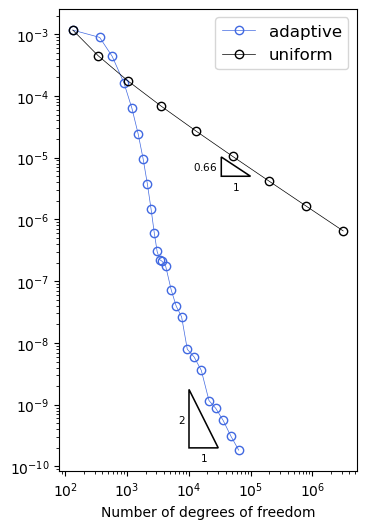

In [240]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.3*1e5,0.2*1e-9),2,slope=2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.05*1e-4),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

In [254]:
M = Lshape(4,5)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=9, draw=False)
M.draw()

0
Refinement took 0.00015354156494140625 seconds.
1
Refinement took 0.00023245811462402344 seconds.
2
Refinement took 0.00025272369384765625 seconds.
3
Refinement took 0.0002415180206298828 seconds.
4
Refinement took 0.0002295970916748047 seconds.
5
Refinement took 0.0003037452697753906 seconds.
6
Refinement took 0.00034165382385253906 seconds.
7
Refinement took 0.0005028247833251953 seconds.
8


CholmodTooLargeError: ../Supernodal/cholmod_super_symbolic.c:683: problem too large (code -3)

1
0


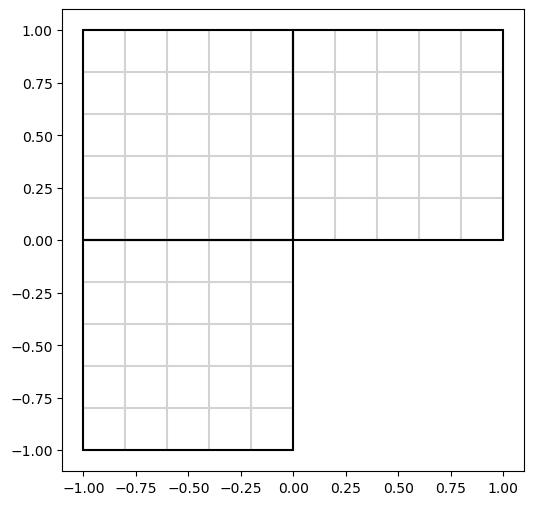

Residual contributions took 0.020650625228881836 seconds.
Jump contributions took 0.01316690444946289 seconds.
Estimate and Marking took 0.03397250175476074 seconds.
Refinement took 0.008510351181030273 seconds.

1


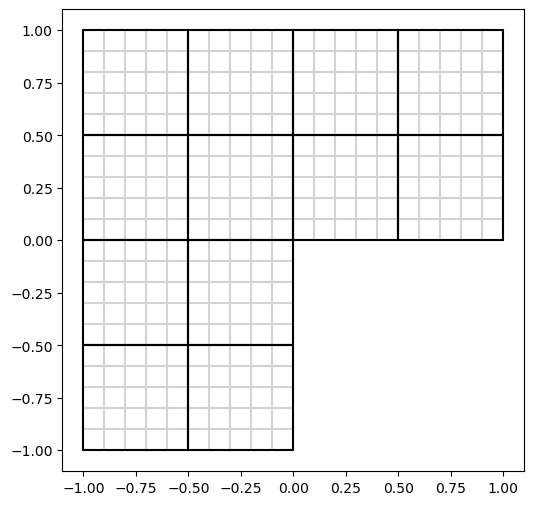

Residual contributions took 0.07957124710083008 seconds.
Jump contributions took 0.1064291000366211 seconds.
Estimate and Marking took 0.18616127967834473 seconds.
Refinement took 0.010097503662109375 seconds.

2


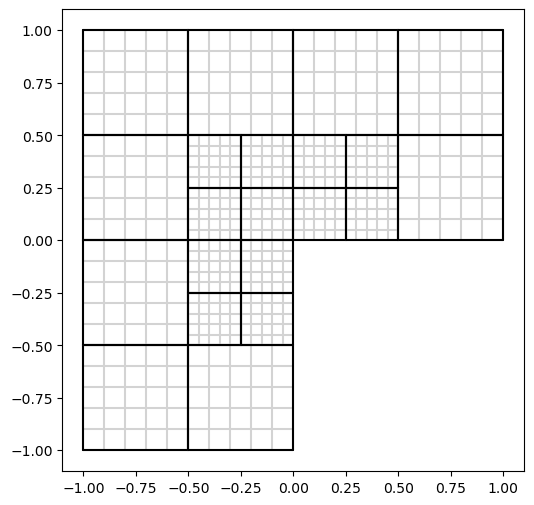

Residual contributions took 0.12996864318847656 seconds.
Jump contributions took 0.2387995719909668 seconds.
Estimate and Marking took 0.36931467056274414 seconds.
Refinement took 0.012935400009155273 seconds.

3


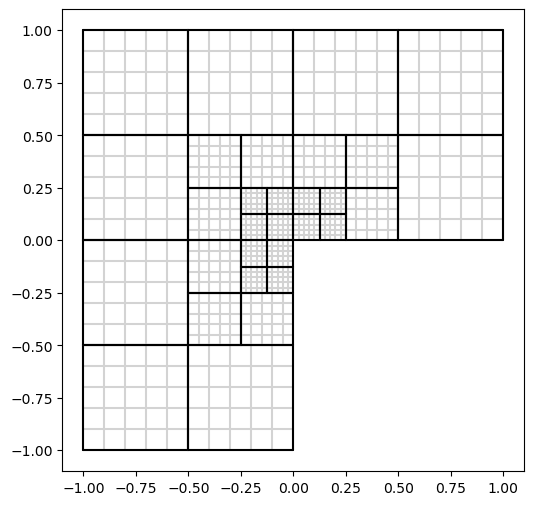

Residual contributions took 0.18905401229858398 seconds.
Jump contributions took 0.3822367191314697 seconds.
Estimate and Marking took 0.5717771053314209 seconds.
Refinement took 0.014523983001708984 seconds.

4


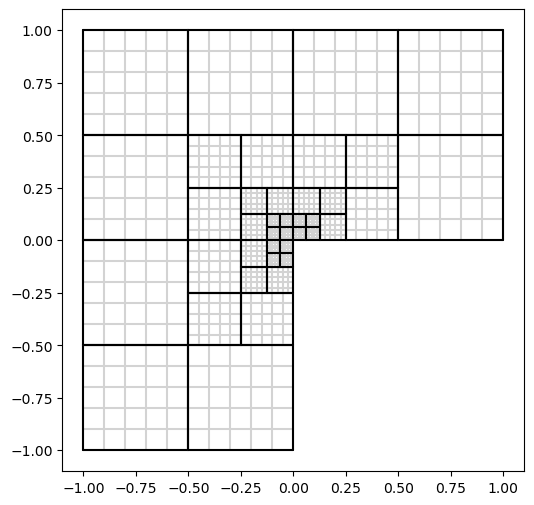

Residual contributions took 0.251096248626709 seconds.
Jump contributions took 0.5257279872894287 seconds.
Estimate and Marking took 0.7770850658416748 seconds.
Refinement took 0.0166318416595459 seconds.

5


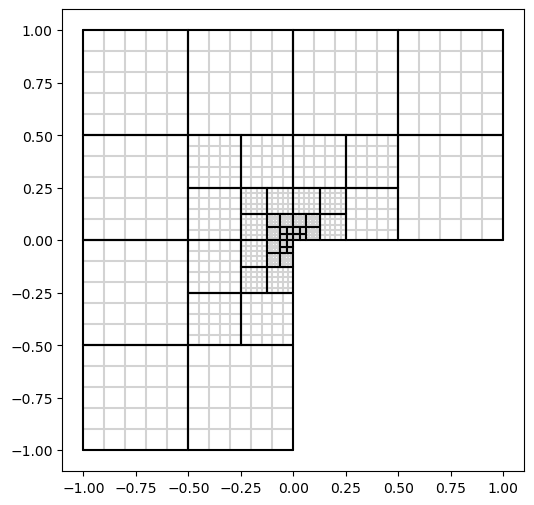

Residual contributions took 0.29926371574401855 seconds.
Jump contributions took 0.6569766998291016 seconds.
Estimate and Marking took 0.9567971229553223 seconds.
Refinement took 0.01838231086730957 seconds.

6


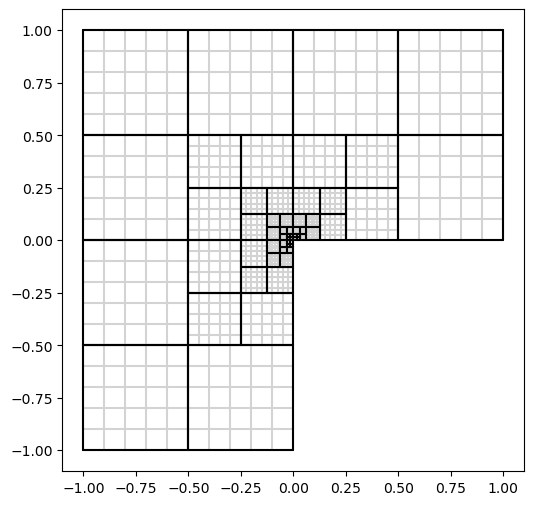

Residual contributions took 0.35369062423706055 seconds.
Jump contributions took 0.7919135093688965 seconds.
Estimate and Marking took 1.1462559700012207 seconds.
Refinement took 0.020965099334716797 seconds.

7


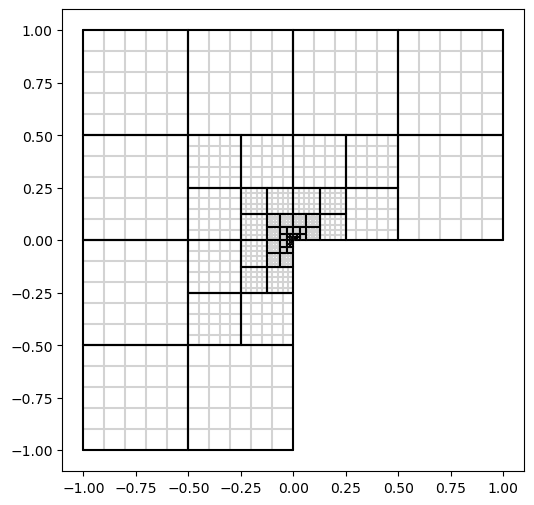

Residual contributions took 0.4075958728790283 seconds.
Jump contributions took 0.9308862686157227 seconds.
Estimate and Marking took 1.3387622833251953 seconds.
Refinement took 0.022440195083618164 seconds.

8


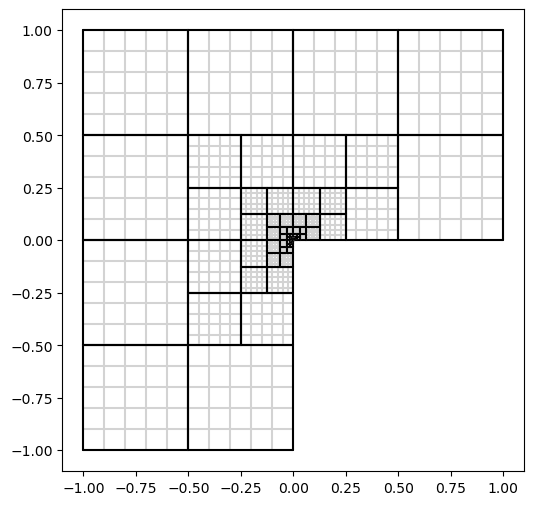

Residual contributions took 0.46224045753479004 seconds.
Jump contributions took 1.068678855895996 seconds.
Estimate and Marking took 1.5311858654022217 seconds.
Refinement took 0.02449512481689453 seconds.

9


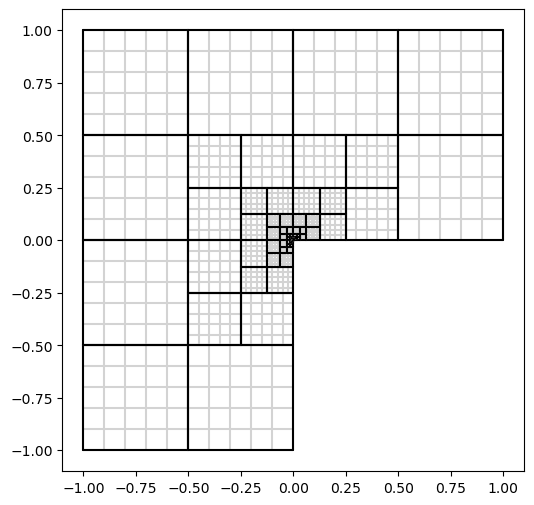

Residual contributions took 0.5285191535949707 seconds.
Jump contributions took 1.2115461826324463 seconds.
Estimate and Marking took 1.7403669357299805 seconds.
Refinement took 0.02652430534362793 seconds.

10


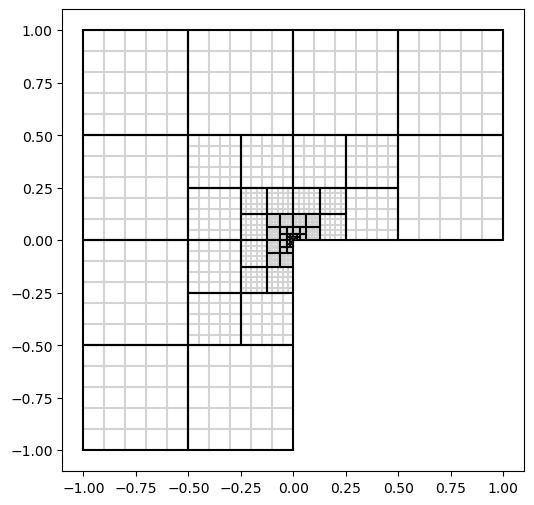

Residual contributions took 0.5951464176177979 seconds.
Jump contributions took 1.3445188999176025 seconds.
Estimate and Marking took 1.9399526119232178 seconds.
Refinement took 0.028524398803710938 seconds.

11


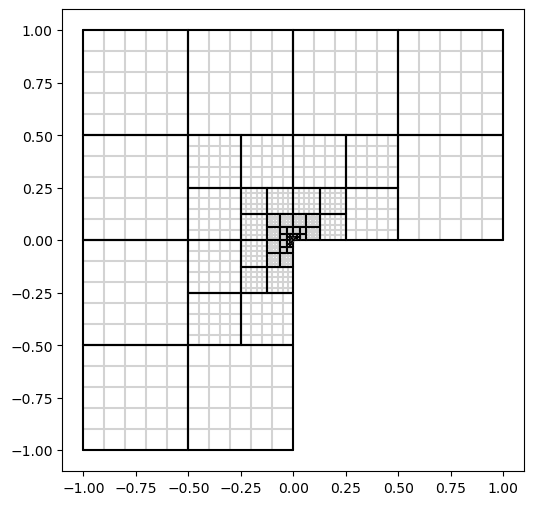

Residual contributions took 0.6461341381072998 seconds.
Jump contributions took 1.5015122890472412 seconds.
Estimate and Marking took 2.147982120513916 seconds.
Refinement took 0.03111743927001953 seconds.

12


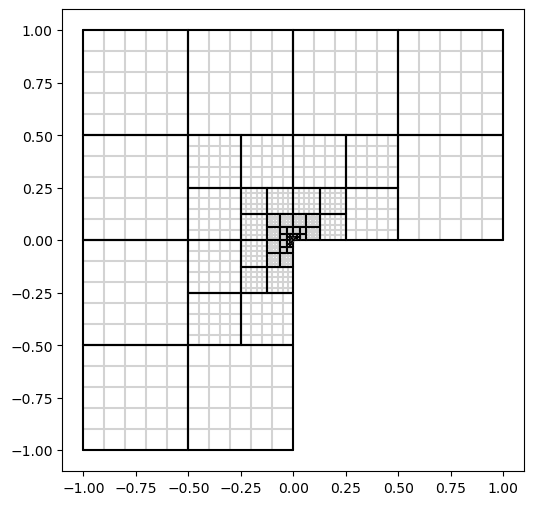

Residual contributions took 0.6992189884185791 seconds.
Jump contributions took 1.6154370307922363 seconds.
Estimate and Marking took 2.315001964569092 seconds.
Refinement took 0.033327579498291016 seconds.

13


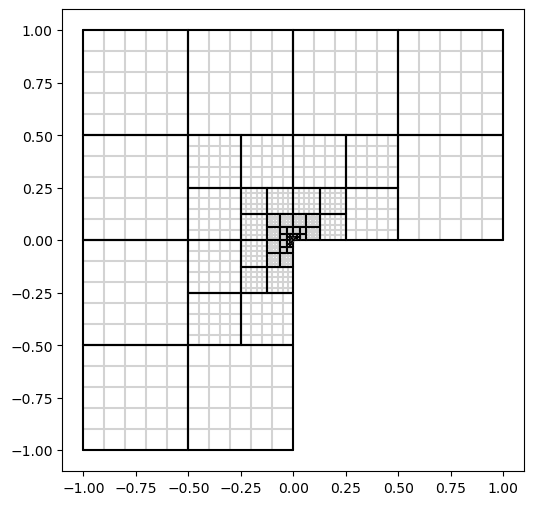

Residual contributions took 0.754000186920166 seconds.
Jump contributions took 1.8550689220428467 seconds.
Estimate and Marking took 2.6095712184906006 seconds.
Refinement took 0.03667092323303223 seconds.

14


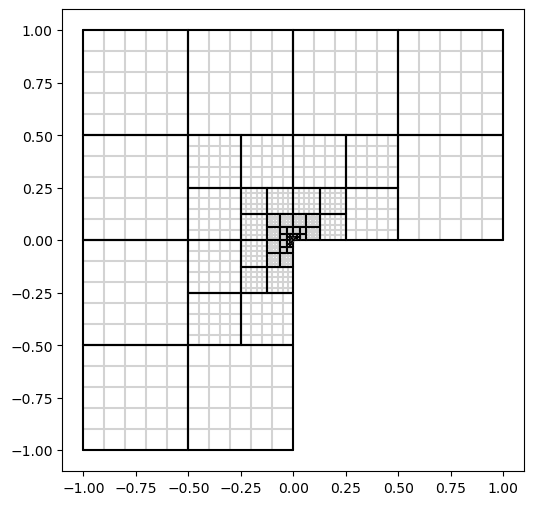

Residual contributions took 0.8244433403015137 seconds.
Jump contributions took 1.8870387077331543 seconds.
Estimate and Marking took 2.7118189334869385 seconds.
Refinement took 0.03613710403442383 seconds.

15


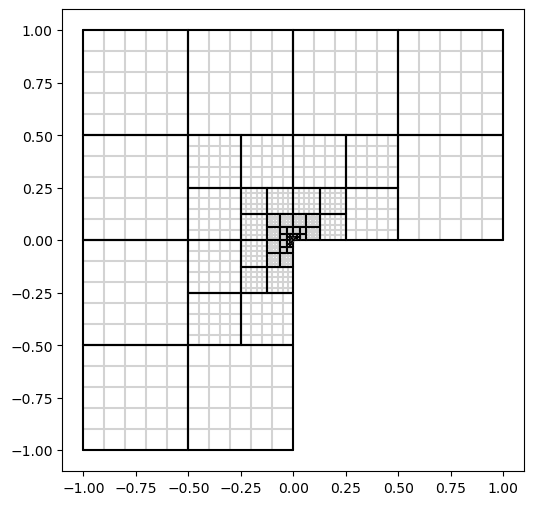

Residual contributions took 0.8810679912567139 seconds.
Jump contributions took 2.0233020782470703 seconds.
Estimate and Marking took 2.904675006866455 seconds.
Refinement took 0.038181304931640625 seconds.

16


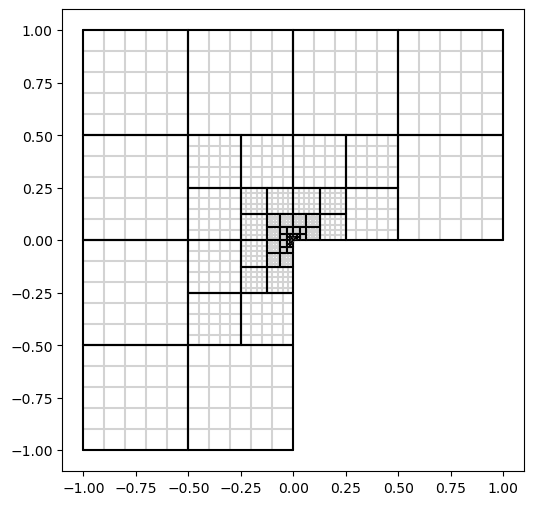

Residual contributions took 0.9142296314239502 seconds.
Jump contributions took 2.1654515266418457 seconds.
Estimate and Marking took 3.080293655395508 seconds.
Refinement took 0.03934741020202637 seconds.

17


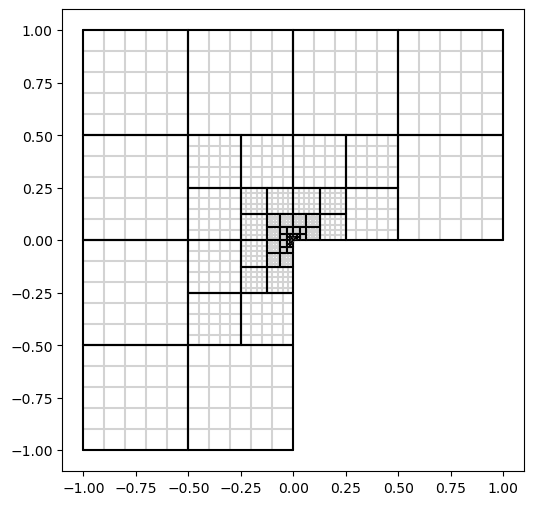

Residual contributions took 0.9691939353942871 seconds.
Jump contributions took 2.2867026329040527 seconds.
Estimate and Marking took 3.2562203407287598 seconds.
Refinement took 0.04179501533508301 seconds.

18


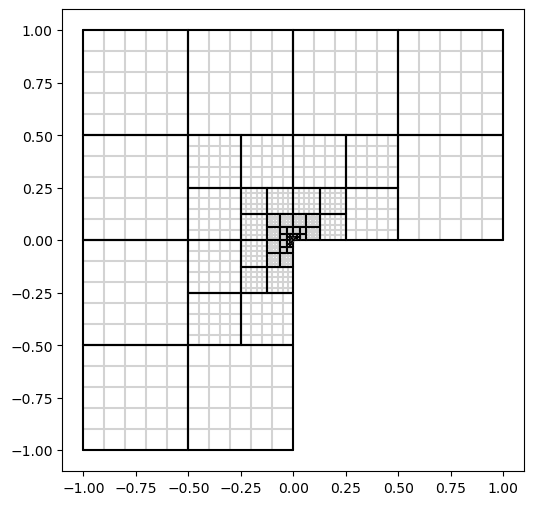

Residual contributions took 1.089613676071167 seconds.
Jump contributions took 2.4318230152130127 seconds.
Estimate and Marking took 3.5217721462249756 seconds.
Refinement took 0.04396820068359375 seconds.

19


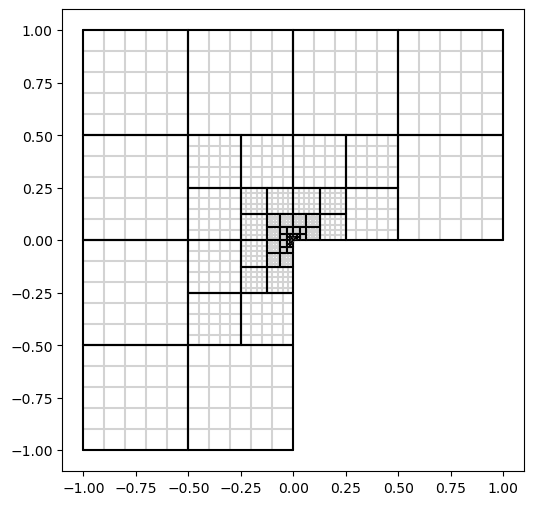

Residual contributions took 1.0806043148040771 seconds.
Jump contributions took 2.568394184112549 seconds.
Estimate and Marking took 3.6493570804595947 seconds.
Refinement took 0.04547739028930664 seconds.

20


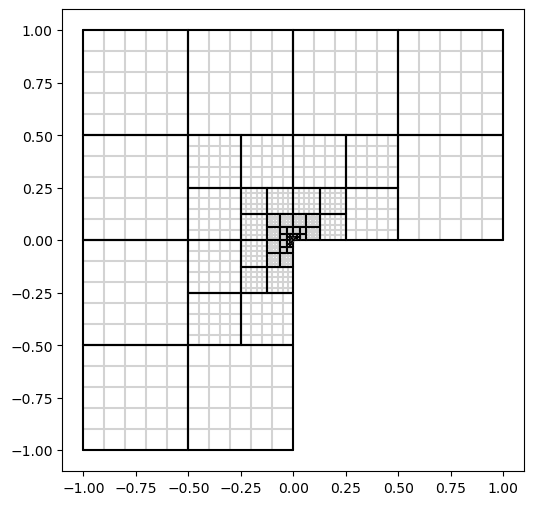

Residual contributions took 1.1512367725372314 seconds.
Jump contributions took 2.7180354595184326 seconds.
Estimate and Marking took 3.8699443340301514 seconds.
Refinement took 0.049156904220581055 seconds.

21


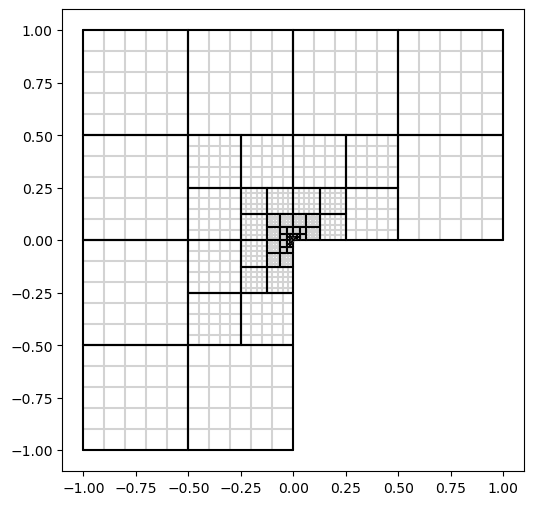

Residual contributions took 1.216332197189331 seconds.
Jump contributions took 2.837141990661621 seconds.
Estimate and Marking took 4.054126024246216 seconds.
Refinement took 0.0488736629486084 seconds.

22


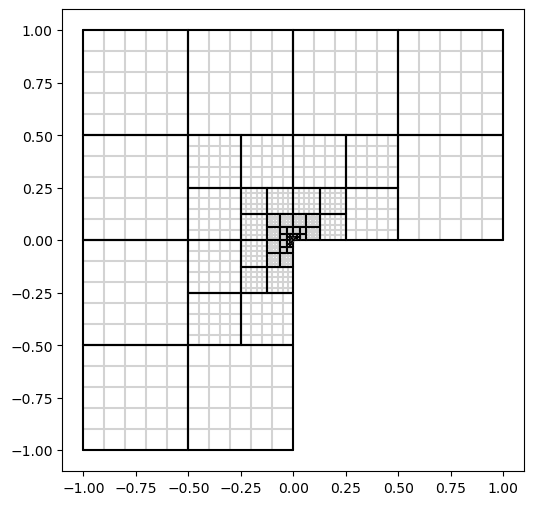

Residual contributions took 1.2893986701965332 seconds.
Jump contributions took 2.9841086864471436 seconds.
Estimate and Marking took 4.2741944789886475 seconds.
Refinement took 0.13922452926635742 seconds.

23


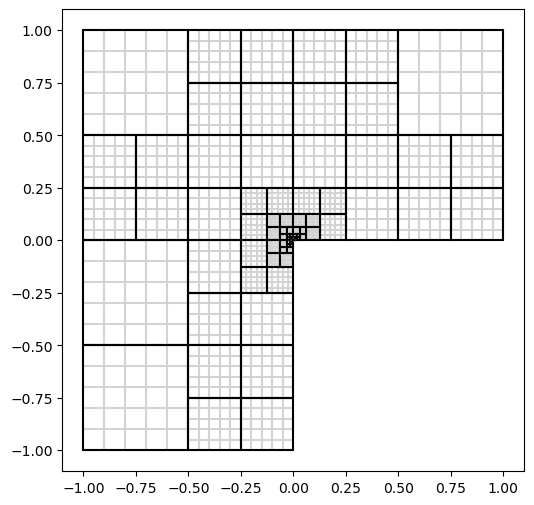

Residual contributions took 1.4448025226593018 seconds.
Jump contributions took 3.301848888397217 seconds.
Estimate and Marking took 4.747355699539185 seconds.
Refinement took 0.17220139503479004 seconds.

24


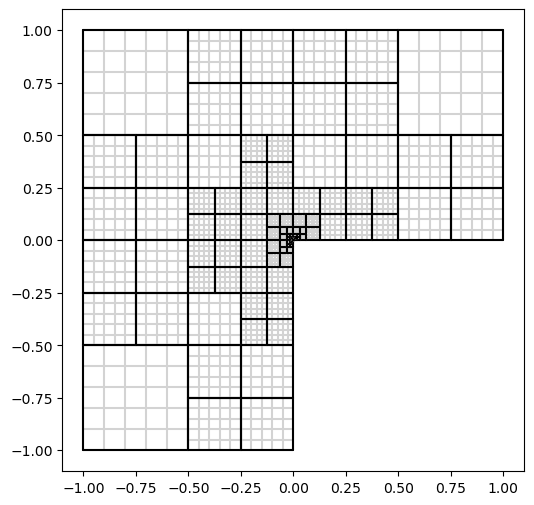

Residual contributions took 1.6307411193847656 seconds.
Jump contributions took 3.731083393096924 seconds.
Estimate and Marking took 5.3625500202178955 seconds.
Refinement took 0.1875300407409668 seconds.

25


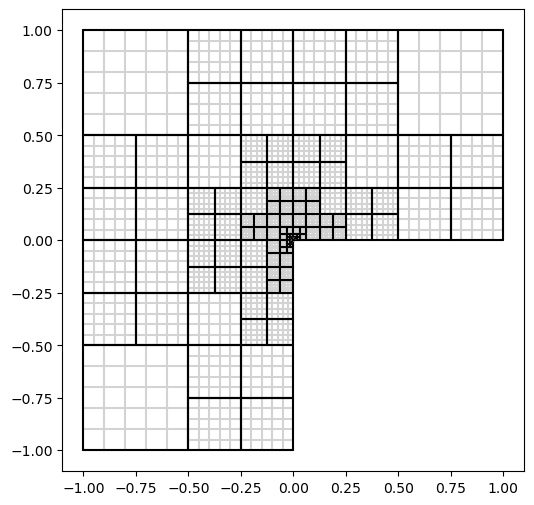

Residual contributions took 1.823732614517212 seconds.
Jump contributions took 4.172735214233398 seconds.
Estimate and Marking took 5.99726128578186 seconds.
Refinement took 0.27751755714416504 seconds.

26


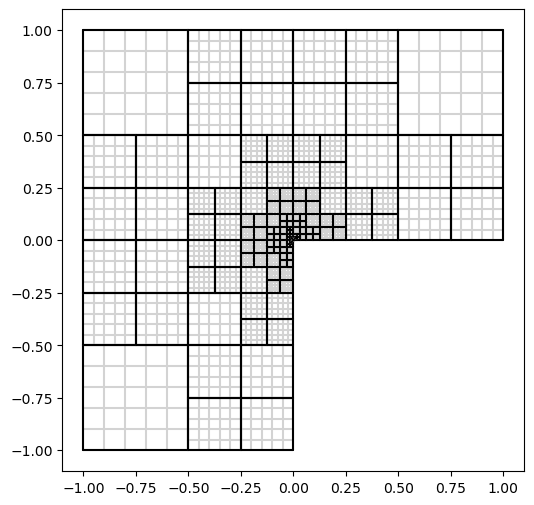

Residual contributions took 1.9895284175872803 seconds.
Jump contributions took 4.591368198394775 seconds.
Estimate and Marking took 6.581641674041748 seconds.
Refinement took 0.3281745910644531 seconds.

27


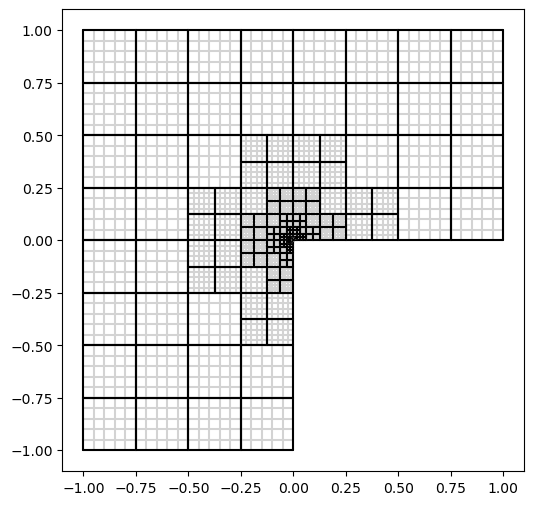

Residual contributions took 2.253469944000244 seconds.
Jump contributions took 5.077566862106323 seconds.
Estimate and Marking took 7.331822156906128 seconds.
Refinement took 0.38580870628356934 seconds.

28


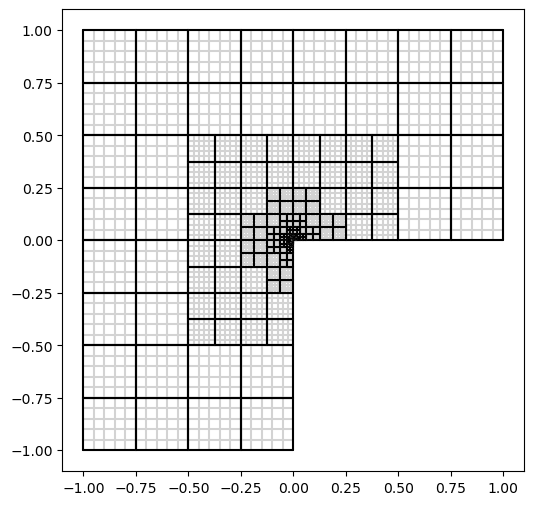

Residual contributions took 2.5291805267333984 seconds.
Jump contributions took 5.6715781688690186 seconds.
Estimate and Marking took 8.201542615890503 seconds.
Refinement took 0.5844552516937256 seconds.

29


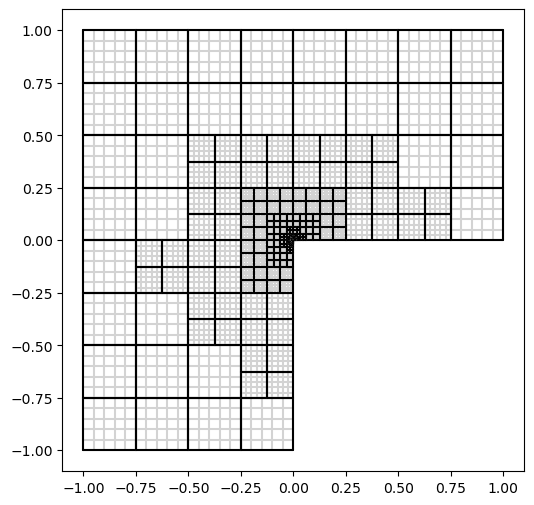

Residual contributions took 2.844757556915283 seconds.
Jump contributions took 6.514358758926392 seconds.
Estimate and Marking took 9.359963417053223 seconds.
Refinement took 0.819124698638916 seconds.

30


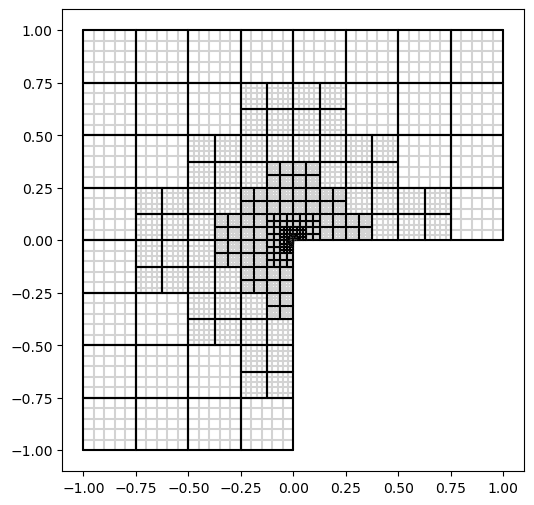

Residual contributions took 3.3619184494018555 seconds.
Jump contributions took 7.557915687561035 seconds.
Estimate and Marking took 10.920750141143799 seconds.
Refinement took 1.13356351852417 seconds.

31


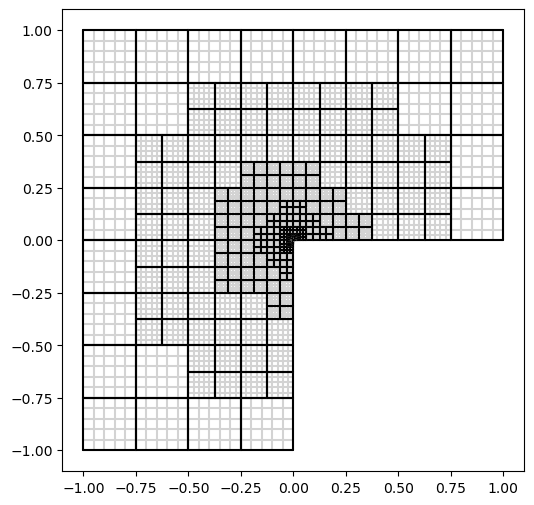

Residual contributions took 3.877429246902466 seconds.
Jump contributions took 8.764891624450684 seconds.
Estimate and Marking took 12.643351316452026 seconds.
Refinement took 1.6046726703643799 seconds.

32


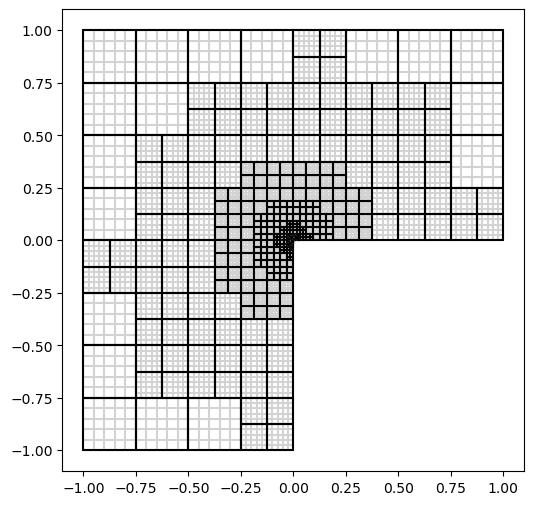

Residual contributions took 4.574916362762451 seconds.
Jump contributions took 10.277218580245972 seconds.
Estimate and Marking took 14.853216648101807 seconds.
Refinement took 2.3057212829589844 seconds.

33


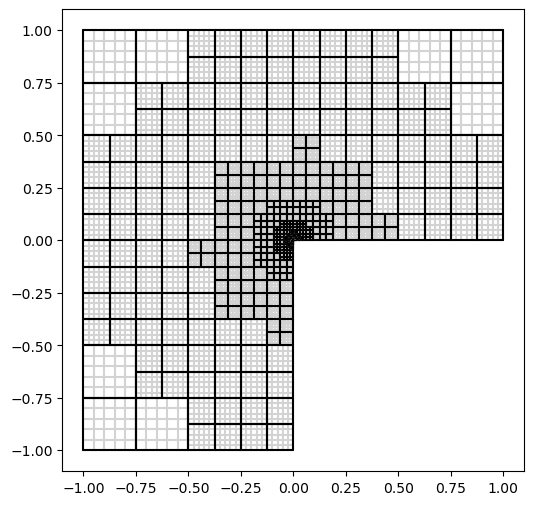

Residual contributions took 5.481000900268555 seconds.
Jump contributions took 12.132431745529175 seconds.
Estimate and Marking took 17.614620208740234 seconds.
Refinement took 2.848871946334839 seconds.

34


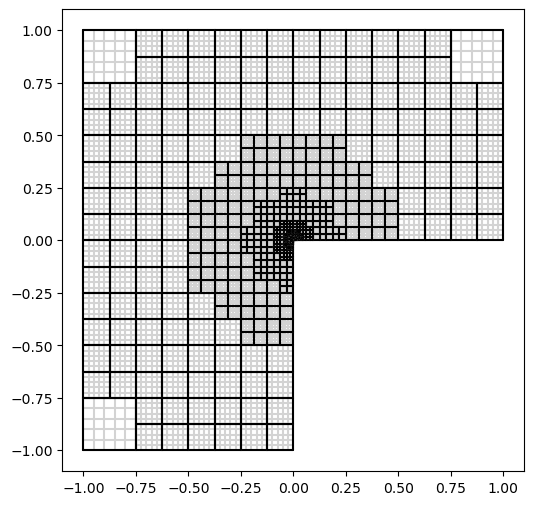

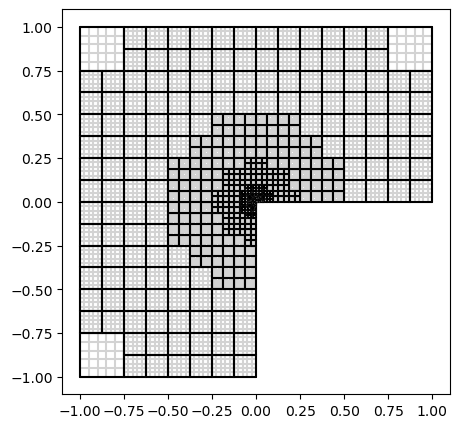

In [244]:
M = Lshape(4,5)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=35)
M.draw()

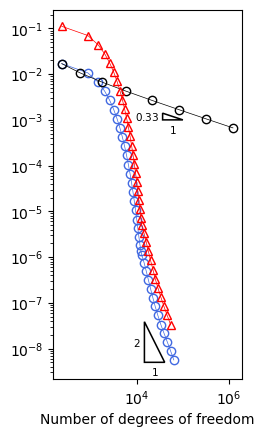

In [265]:
fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.4*1e5,0.5*1e-8),2,2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.1*1e-2),2,0.33,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()

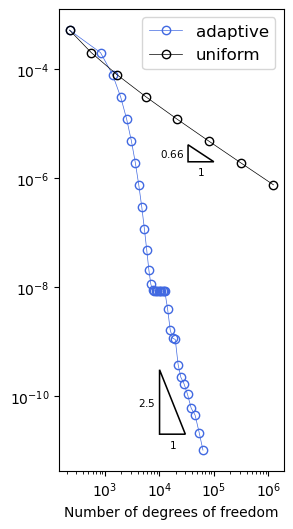

In [262]:
fig, ax = plt.subplots(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='upper right',prop={'size': 12})
plt.xlabel("Number of degrees of freedom")
draw_loglog_slope(fig,ax,(0.3*1e5,0.2*1e-10),2,slope=2.5,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,0.2*1e-5),2,0.66,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
axis('scaled');
plt.show()